In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tikzplotlib as tpl

In [2]:
from scipy.special import gamma
from scipy.linalg import expm, sqrtm, logm
from scipy.stats import multivariate_normal as mv_norm
from scipy.stats import wishart, chi2

%matplotlib inline

In [3]:
#helper functions
def is_pos_def(x):
    eig = np.linalg.eigvals(x)
    pd = np.all(eig > 0)
    if not pd:
        raise(ValueError("Psi matrix is not positive definite! Matrix: {}; Eigenvalues: {}".format(x, eig)))
    else:
        return(True)
    
def my_kron_product(A, B):
    m1, n1 = A.shape[0], A.shape[1]
    m2, n2 = B.shape[0], B.shape[1]
    K = np.zeros((m1*m2, n1*n2))
    for i in range(m1):
        for j in range(m2):
            for k in range(n1):
                for l in range(n2):
                    K[i*m2 +j, k*n2 + l] = A[i,k] * B[j,l]
    
    return(K)
    
def my_box_product(A, B):
    m1, n1 = A.shape[0], A.shape[1]
    m2, n2 = B.shape[0], B.shape[1]
    K = np.zeros((m1*m2, n1*n2))
    for i in range(m1):
        for j in range(m2):
            for k in range(n1):
                for l in range(n2):
                    K[i*m2 +j, k*n1 + l] = A[i,l] * B[j,k]
    
    return(K)

# return a cut through a 2D psd_cone, given values for the 
# a_11 and a_22 position of the matrix and a constant rho
def make_2D_psd_cone_cut(a_11, a_22, rho):
    xx = []
    
    for i in range(len(a_11)):
        a_12 = rho*np.sqrt(a_11[i] * a_22[i])
        matrix = np.array([[a_11[i], a_12],[a_12, a_22[i]]])
        is_pos_def(matrix)
        xx.append(matrix)
        
    return(xx)

def multi_variate_gamma(p, a):
    a = np.pi**(p*(p-1)/4) 
    b = np.prod([gamma(a + (1-j)/2) for j in range(1, p + 1)])
    return(a*b)

def create_spd_matrix(p=2, eps=10e-3):
    
    #create two symmetric positive-definite matrices
    X_ = torch.rand(p,p)
    X_sym = (X_ + X_.T)/2
    lambda_X_min = torch.abs(torch.min(torch.eig(X_sym, False)[0])) + eps
    X_spd = X_sym + torch.eye(p) * lambda_X_min
    print("X_spd is spd: ", is_pos_def(X_spd))
    
    return(X_spd.cpu().numpy())

    

(301, 2, 2)
(301,)


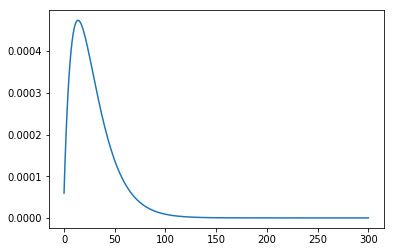

In [4]:
# test the make_2D_psd_cone_cut function
a_11 = np.linspace(0.1, 30.1, 300 +1)
a_22 = np.linspace(0.1, 60.1, 300 +1)
rho = 0

s = np.array([[4,2],
             [2,3]])
is_pos_def(s)

xx = make_2D_psd_cone_cut(a_11, a_22, rho)

w = []
print(np.shape(xx))
for x in xx:
    w_ = wishart.pdf(x, df=4, scale=s)
    w.append(w_)
print(np.shape(w))

plt.plot(w);
plt.show()

# Wishart Distribution Laplace Propagation

In [12]:
def wishart_pdf(X, n, V):
    p = np.shape(X)[0]
    nom = np.linalg.det(X)**((n-p-1)/2) * np.exp(-np.trace(np.linalg.inv(V) @ X)/2)
    den = 2**(n*p/2) * np.linalg.det(V)**(n/2) * multi_variate_gamma(p, n/2)
    return(nom/den)

def wishart_pdf_t_sqrtm(X, n, V):
    p = np.shape(X)[0]
    nom = np.linalg.det(X)**(n-p) * np.exp(-np.trace(np.linalg.inv(V) @ (X@X))/2) 
    den = 2**(n*p/2) * np.linalg.det(V)**(n/2) * multi_variate_gamma(p, n/2)
    return(nom/den)

def wishart_pdf_t_logm(X, n, V):
    p = np.shape(X)[0]
    nom = np.linalg.det(expm(X))**(n-p)/2 * np.exp(-np.trace(np.linalg.inv(V) @ expm(X))/2) 
    den = 2**(n*p/2) * np.linalg.det(V)**(n/2) * multi_variate_gamma(p, n/2)
    return(nom/den)
   
def multivariate_normal_pdf_test(X, mu, Sigma):
    k = np.shape(X)[0]
    a = (2*np.pi)**(-k/2) * np.linalg.det(Sigma)**(-1/2)
    x_mu = (X-mu).reshape(-1)
    b = np.exp(-1/2 * x_mu.T @ np.linalg.inv(Sigma) @ x_mu)
    return(a*b)

def square_mv_normal_back(X, mu, Sigma):
    X_ = sqrtm(X).reshape(-1)
    mu = mu.reshape(-1)
    return(mv_norm.pdf(X_, mu, Sigma) * np.linalg.det(sqrtm(X)))

def log_mv_normal_back(X, mu, Sigma):
    X_ = logm(X).reshape(-1)
    mu = mu.reshape(-1)
    return(mv_norm.pdf(X_, mu, Sigma) * np.linalg.det(np.linalg.inv(X)))

def wishart_mode(n, p, V):
    return((n-p-1) * V)

def wishart_Sigma(n, p, V):
    return(2*(n-p-1) * my_kron_product(V, V))

def wishart_t_sqrtm_mode(n,p,V):
    return(sqrtm((n-p)*V))

def wishart_t_sqrtm_Sigma(n,p,V, mode):
    V_inv = np.linalg.inv(V)
    V_inv_sqrtm = sqrtm(V_inv)
    I_p = np.eye(p)
    #one = (n-p) * my_kron_product(np.linalg.inv(mode).T, np.linalg.inv(mode))
    #two = -0.5 * my_box_product(np.linalg.inv(V), np.eye(p)) + my_box_product(np.eye(p), np.linalg.inv(V))
    one = my_kron_product(V_inv_sqrtm, V_inv_sqrtm)
    two = -0.5 * my_box_product(V_inv, I_p) + my_box_product(I_p, V_inv)
    return(np.linalg.inv(one + two))

def wishart_t_logm_mode(n, p, V):
    return(logm((n-p+1) * V))

def wishart_t_logm_Sigma(n, p, V, mode):
    return(2/(n-p+1) * np.eye(p**2))
    

In [13]:
mode1 = wishart_t_sqrtm_mode(n=5, p=2, V=s)
wishart_t_sqrtm_Sigma(n=5, p=2, V=s, mode=mode1)

array([[ 1.84862476,  0.04359094,  1.69876335,  0.81804191],
       [ 1.69876335,  2.37855343, -0.56126844, -0.36543002],
       [ 0.04359094,  0.26631777,  2.37855343,  1.2897424 ],
       [ 0.81804191,  1.2897424 , -0.36543002,  1.18195809]])

## sqrtm basis

In [14]:
# function that creates a fancy plot for three different values of n
# the plot contains the original Laplace approximation, the Bridge, and a back transform

def plot_Wishart_bridge_sqrtm(xx, ns, s, p=2, save=False):
    
    n1, n2, n3 = ns
    
    ##### normal laplace
    
    mode1 = wishart_mode(n1, p=p, V=s)
    mode2 = wishart_mode(n2, p=p, V=s)
    mode3 = wishart_mode(n3, p=p, V=s)
    #print("mode1: ", mode1)
    #print("mode2: ", mode2)
    #print("mode3: ", mode3)

    sigma1 = wishart_Sigma(n1, p=p, V=s)
    sigma2 = wishart_Sigma(n2, p=p, V=s)
    sigma3 = wishart_Sigma(n3, p=p, V=s)
    #print("sigma1: ", sigma1)
    #print("sigma2: ", sigma2)
    #print("sigma3: ", sigma3)
    
    is_pos_def(sigma1)
    is_pos_def(sigma2)
    is_pos_def(sigma3)

    w1 = []
    w2 = []
    w3 = []
    normal1 = []
    normal2 = []
    normal3 = []

    print(np.shape(xx))
    for x in xx:
        w_1 = wishart_pdf(X=x, n=n1, V=s)
        w_2 = wishart_pdf(X=x, n=n2, V=s)
        w_3 = wishart_pdf(X=x, n=n3, V=s)
        w1.append(w_1)
        w2.append(w_2)
        w3.append(w_3)
        w1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1, Sigma=sigma1)
        w2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2, Sigma=sigma2)
        w3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3, Sigma=sigma3)
        normal1.append(w1_lpa)
        normal2.append(w2_lpa)
        normal3.append(w3_lpa)

    w1 = np.array(w1)
    w2 = np.array(w2)
    w3 = np.array(w3)
    
    rescale_normal1 = np.max(w1)/np.max(normal1)
    rescale_normal2 = np.max(w2)/np.max(normal2)
    rescale_normal3 = np.max(w3)/np.max(normal3)

    normal1 = np.array(normal1) * rescale_normal1
    normal2 = np.array(normal2) * rescale_normal2
    normal3 = np.array(normal3) * rescale_normal3
    

    ######### square transformation

    mode1_t_sqrtm = wishart_t_sqrtm_mode(n1, p=p, V=s)
    mode2_t_sqrtm = wishart_t_sqrtm_mode(n2, p=p, V=s)
    mode3_t_sqrtm = wishart_t_sqrtm_mode(n3, p=p, V=s)

    sigma1_t_sqrtm = wishart_t_sqrtm_Sigma(n1, p=p, V=s, mode=mode1_t_sqrtm)
    sigma2_t_sqrtm = wishart_t_sqrtm_Sigma(n2, p=p, V=s, mode=mode2_t_sqrtm)
    sigma3_t_sqrtm = wishart_t_sqrtm_Sigma(n3, p=p, V=s, mode=mode3_t_sqrtm)

    is_pos_def(sigma1_t_sqrtm)
    is_pos_def(sigma2_t_sqrtm)
    is_pos_def(sigma3_t_sqrtm)

    w1_t_sqrtm = []
    w2_t_sqrtm = []
    w3_t_sqrtm = []
    w1_lpa_t_sqrtm = []
    w2_lpa_t_sqrtm = []
    w3_lpa_t_sqrtm = []

    for x in xx:
        w_1 = wishart_pdf_t_sqrtm(X=x, n=n1, V=s)
        w_2 = wishart_pdf_t_sqrtm(X=x, n=n2, V=s)
        w_3 = wishart_pdf_t_sqrtm(X=x, n=n3, V=s)
        w1_t_sqrtm.append(w_1)
        w2_t_sqrtm.append(w_2)
        w3_t_sqrtm.append(w_3)
        #
        w1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1_t_sqrtm, Sigma=sigma1_t_sqrtm)
        w2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2_t_sqrtm, Sigma=sigma2_t_sqrtm)
        w3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3_t_sqrtm, Sigma=sigma3_t_sqrtm)
        w1_lpa_t_sqrtm.append(w1_lpa)
        w2_lpa_t_sqrtm.append(w2_lpa)
        w3_lpa_t_sqrtm.append(w3_lpa)

    #rescale for visibility
    w1_t_sqrtm = np.array(w1_t_sqrtm)
    w2_t_sqrtm = np.array(w2_t_sqrtm)
    w3_t_sqrtm = np.array(w3_t_sqrtm)
    
    rescale1_t_sqrtm = np.max(w1_t_sqrtm)/np.max(w1_lpa_t_sqrtm)
    rescale2_t_sqrtm = np.max(w2_t_sqrtm)/np.max(w2_lpa_t_sqrtm)
    rescale3_t_sqrtm = np.max(w3_t_sqrtm)/np.max(w3_lpa_t_sqrtm)

    w1_lpa_t_sqrtm = np.array(w1_lpa_t_sqrtm) * rescale1_t_sqrtm
    w2_lpa_t_sqrtm = np.array(w2_lpa_t_sqrtm) * rescale2_t_sqrtm
    w3_lpa_t_sqrtm = np.array(w3_lpa_t_sqrtm) * rescale3_t_sqrtm 

    ######### back transform #########

    w1_back = []
    w2_back = []
    w3_back = []

    for x in xx:
        w1_back.append(square_mv_normal_back(x, mode1_t_sqrtm, sigma1_t_sqrtm))
        w2_back.append(square_mv_normal_back(x, mode2_t_sqrtm, sigma2_t_sqrtm))
        w3_back.append(square_mv_normal_back(x, mode3_t_sqrtm, sigma3_t_sqrtm))
        
    rescale_back1 = np.max(w1)/np.max(w1_back)
    rescale_back2 = np.max(w2)/np.max(w2_back)
    rescale_back3 = np.max(w3)/np.max(w3_back)

    w1_back = np.array(w1_back) * rescale_back1
    w2_back = np.array(w2_back) * rescale_back2 
    w3_back = np.array(w3_back) * rescale_back3 

    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(23, 6))
    axs[0].plot(w1, 'r-')#, label="Wishart with n={}".format(n1));
    axs[0].plot(w2, 'b-')#, label="Wishart with n={}".format(n2));
    axs[0].plot(w3, 'k-', label="Wishart with n={}".format(n3));
    axs[0].plot(normal1, 'r--')#, label="LPA test");
    axs[0].plot(normal2, 'b--')#, label="normal approx of wishart1"'');
    axs[0].plot(normal3, 'k--', label="LPA test");
    axs[0].legend();

    axs[1].plot(w1_t_sqrtm[:100], 'r')#, label="Wishart transformed with n={}".format(n1));
    axs[1].plot(w2_t_sqrtm[:100], 'b')#, label="Wishart transformed with n={}".format(n2));
    axs[1].plot(w3_t_sqrtm[:100], 'k', label="Wishart trans");
    axs[1].plot(w1_lpa_t_sqrtm[:100], 'r--')#, label="Wishart transformed with n={}".format(n1));
    axs[1].plot(w2_lpa_t_sqrtm[:100], 'b--')#, label="Wishart transformed with n={}".format(n2));
    axs[1].plot(w3_lpa_t_sqrtm[:100], 'k--', label="Laplace trans");
    axs[1].legend();

    axs[2].plot(w1, 'r-')#, label="Wishart with n={}".format(n1));
    axs[2].plot(w2, 'b-')#, label="Wishart with n={}".format(n2));
    axs[2].plot(w3, 'k-', label="Wishart with n={}".format(n3));
    axs[2].plot(w1_back, 'r--')
    axs[2].plot(w2_back, 'b--')
    axs[2].plot(w3_back, 'k--', label='back transform')

    if save:
        plt.savefig('wishart_playground_sqrtm.pdf')
    plt.show();

(301, 2, 2)


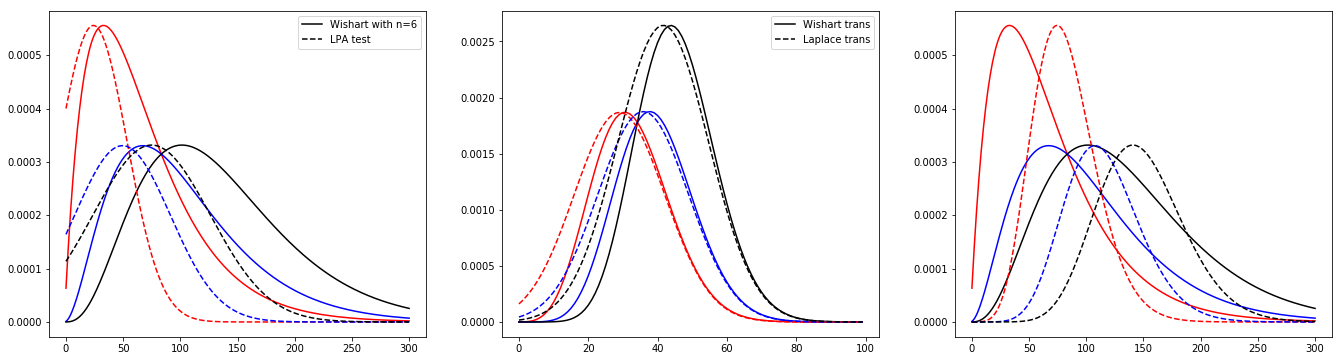

In [15]:
# test the function for one value of rho and s

""" values """
a_11 = np.linspace(0.1, 20.1, 300 +1)
a_22 = np.linspace(0.1, 20.1, 300 +1)

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

#s = 2*np.eye(2)
is_pos_def(s)

r = 0
xxt = make_2D_psd_cone_cut(a_11, a_22, r)

n1 = 4
n2 = 5
n3 = 6

p=2

plot_Wishart_bridge_sqrtm(xx=xxt, ns=[n1,n2,n3], s=s, p=2, save=False)

-0.9
(301, 2, 2)


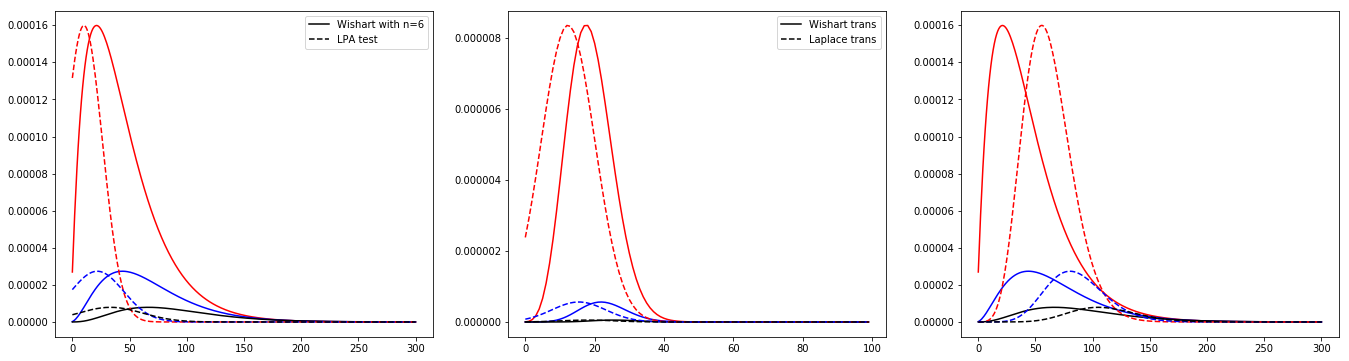

-0.8
(301, 2, 2)


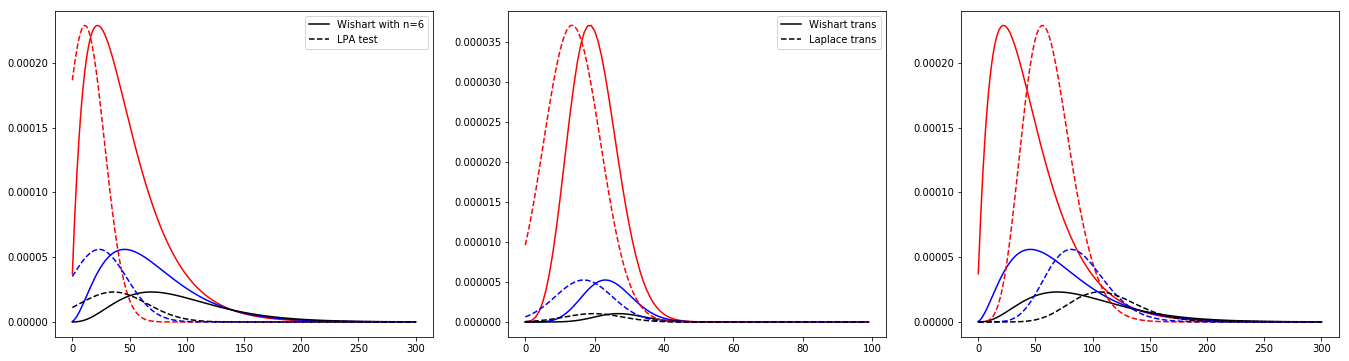

-0.7
(301, 2, 2)


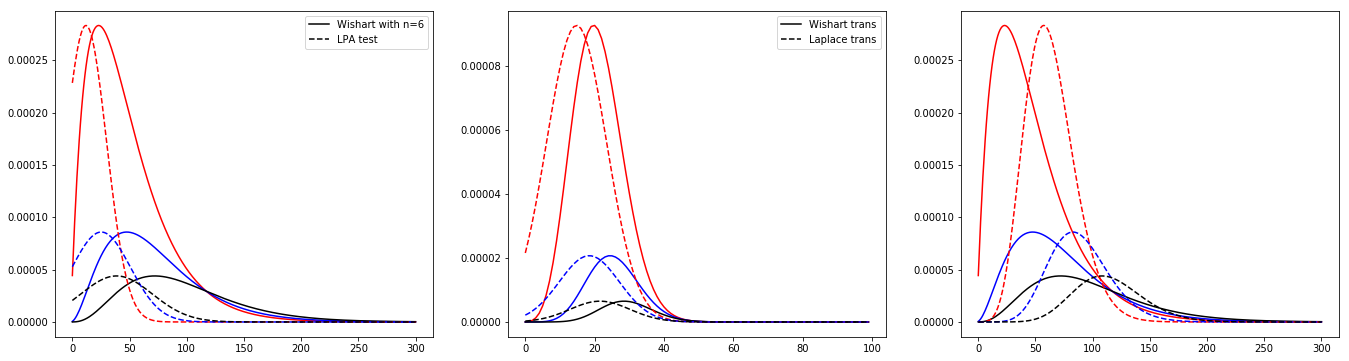

-0.6
(301, 2, 2)


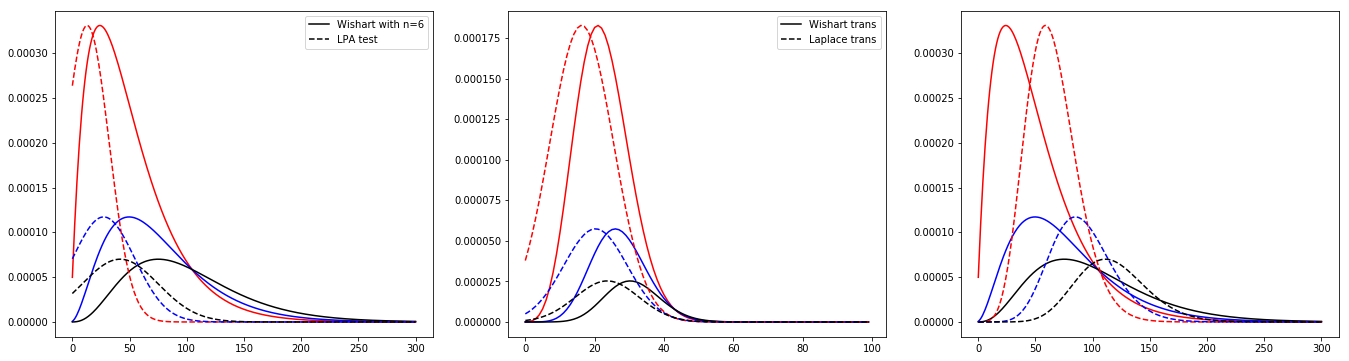

-0.5
(301, 2, 2)


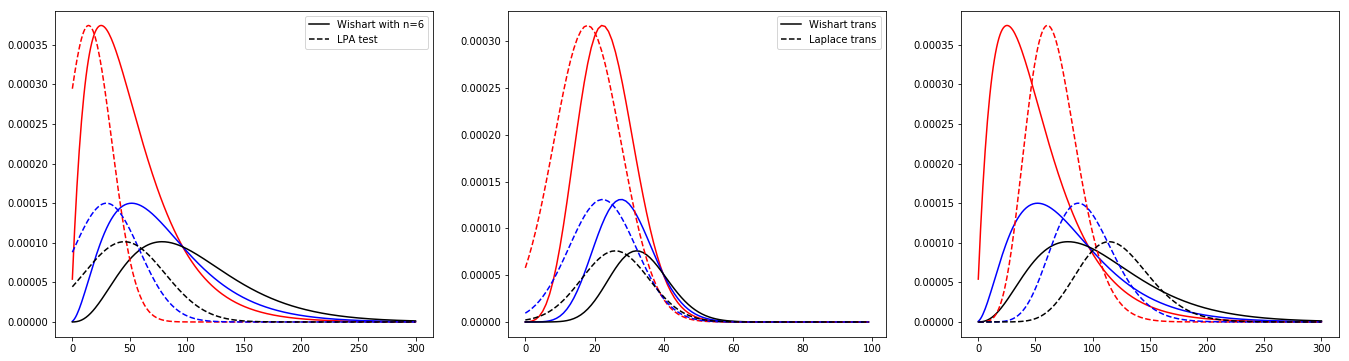

-0.4
(301, 2, 2)


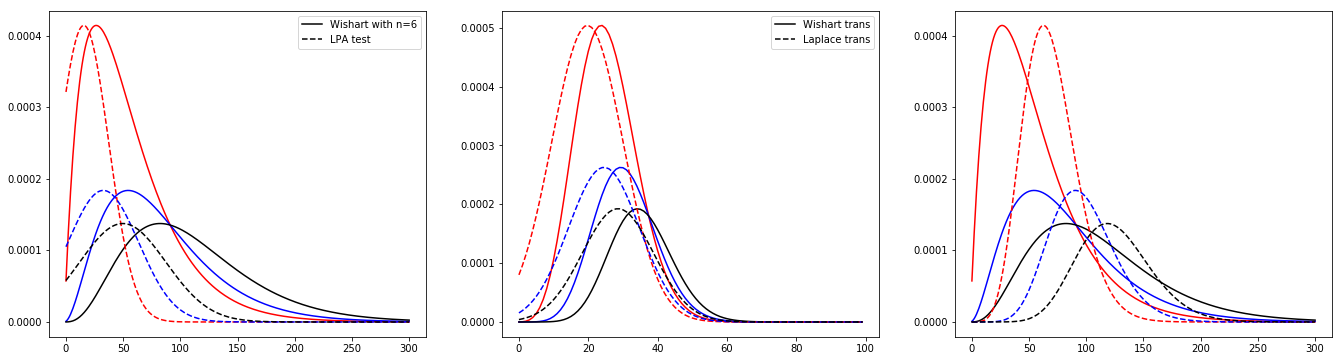

-0.29999999999999993
(301, 2, 2)


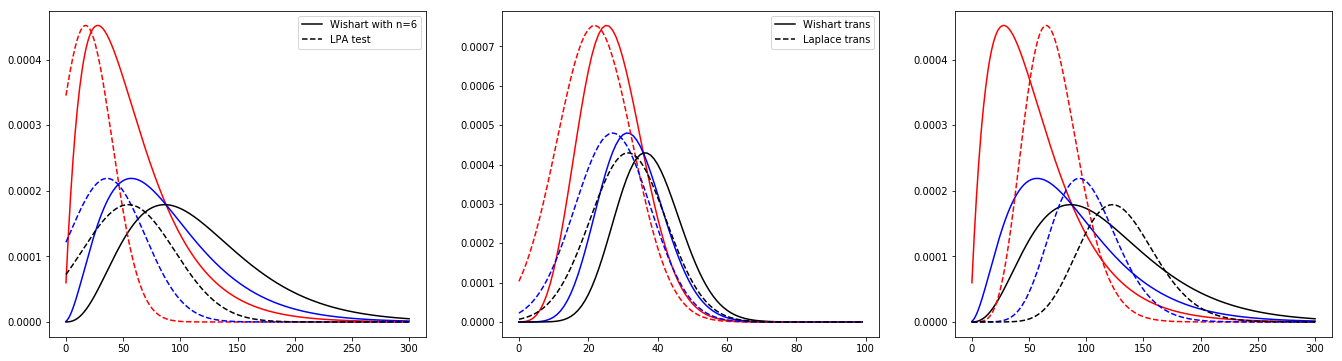

-0.19999999999999996
(301, 2, 2)


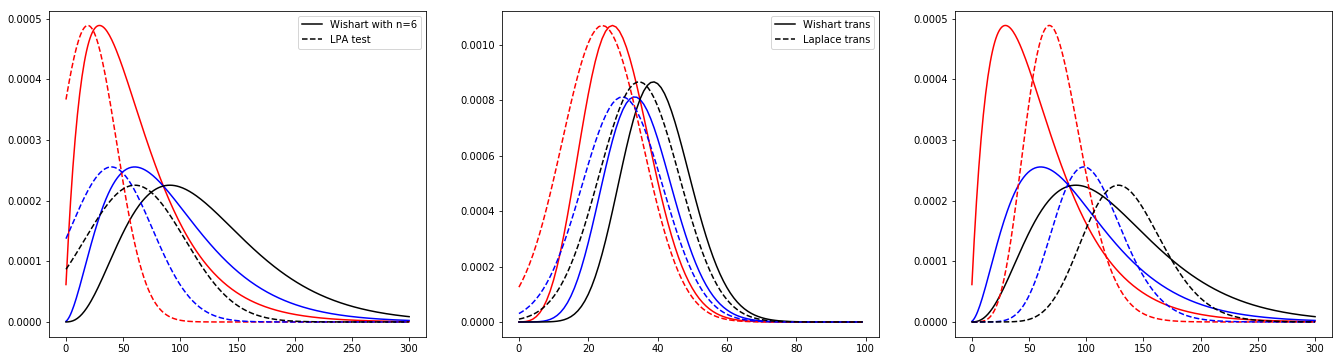

-0.09999999999999998
(301, 2, 2)


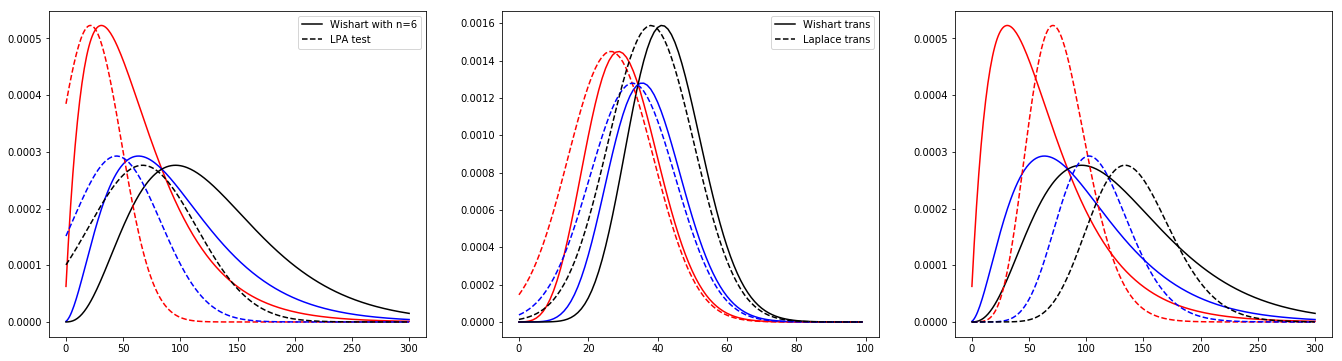

0.0
(301, 2, 2)


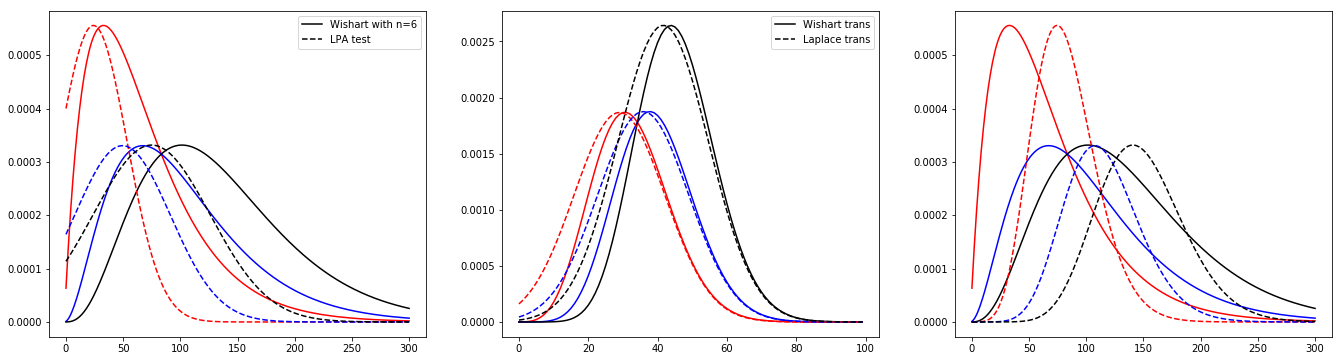

0.09999999999999998
(301, 2, 2)


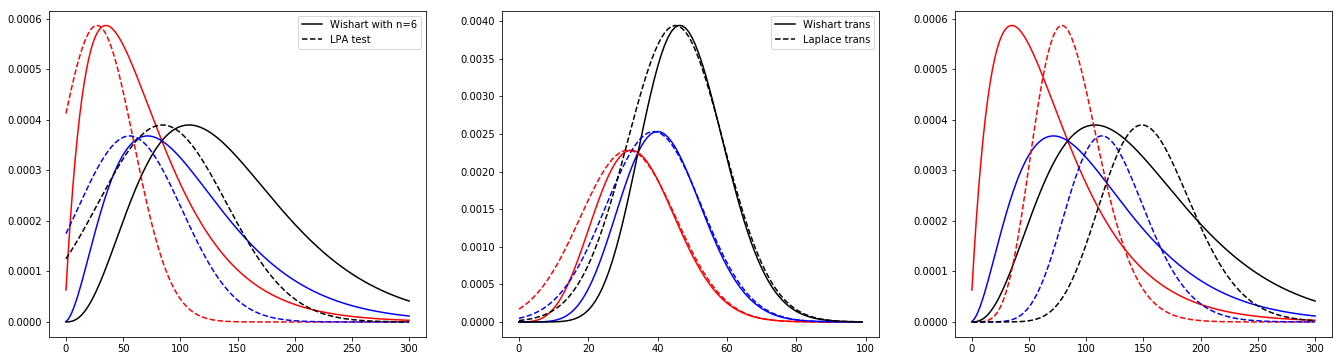

0.20000000000000007
(301, 2, 2)


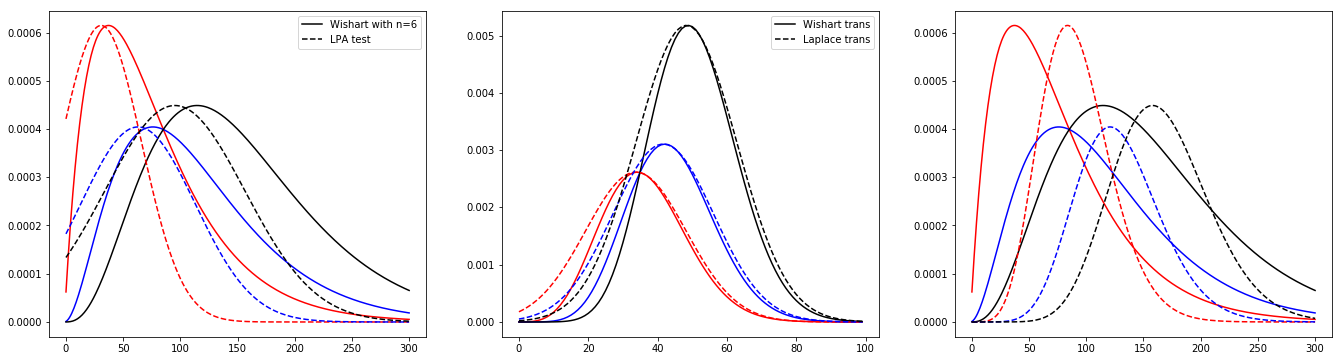

0.30000000000000016
(301, 2, 2)


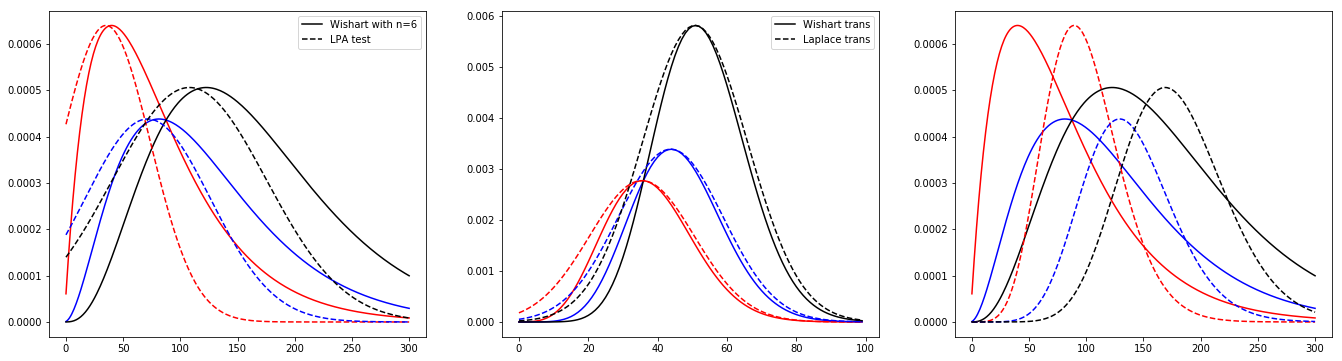

0.4
(301, 2, 2)


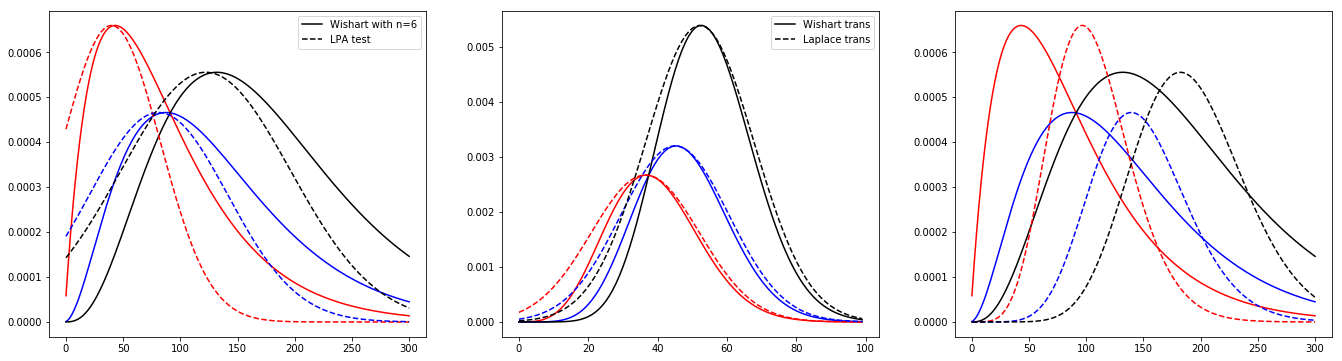

0.5000000000000001
(301, 2, 2)


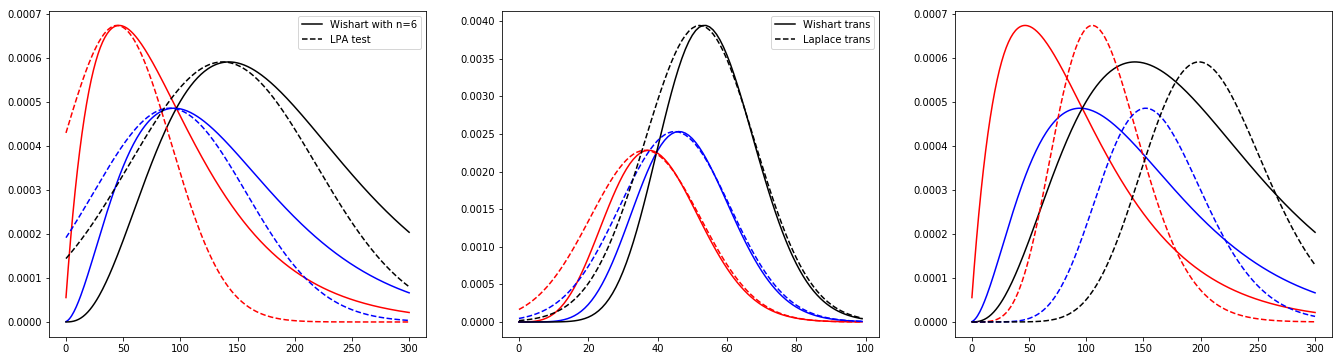

0.6
(301, 2, 2)


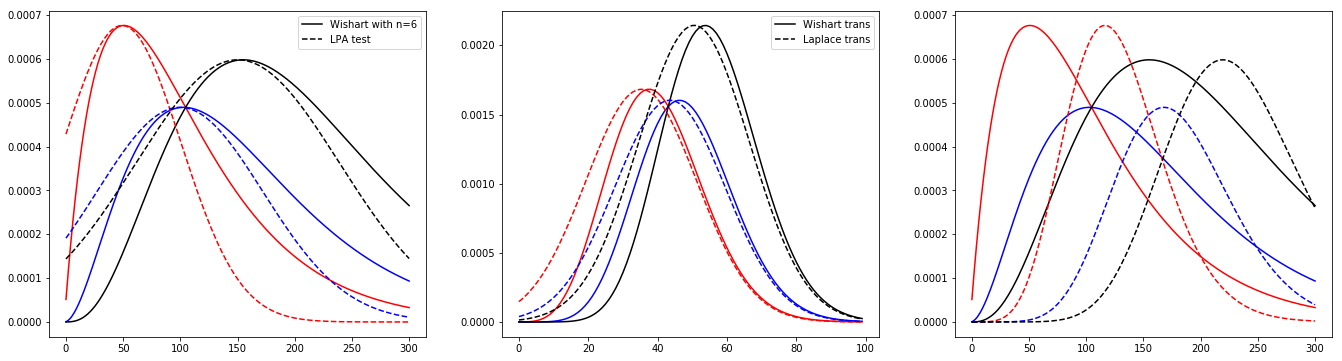

0.7000000000000001
(301, 2, 2)


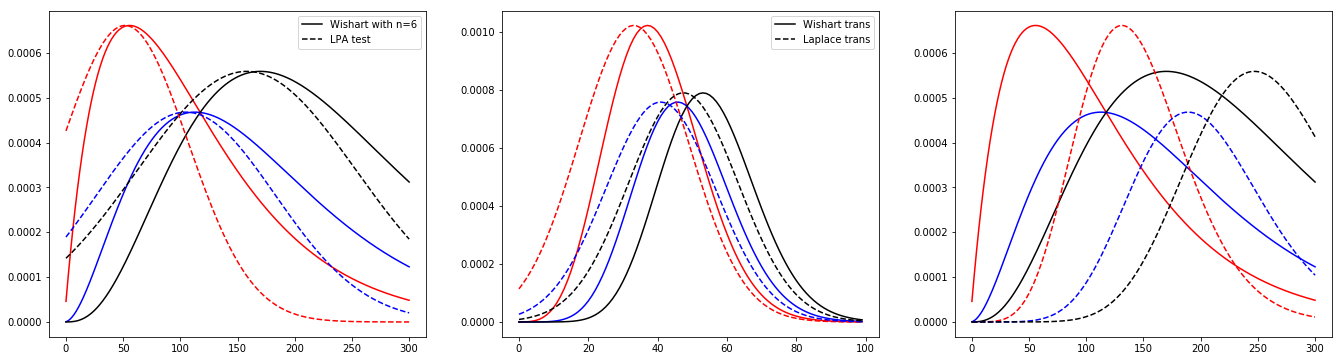

0.8000000000000002
(301, 2, 2)


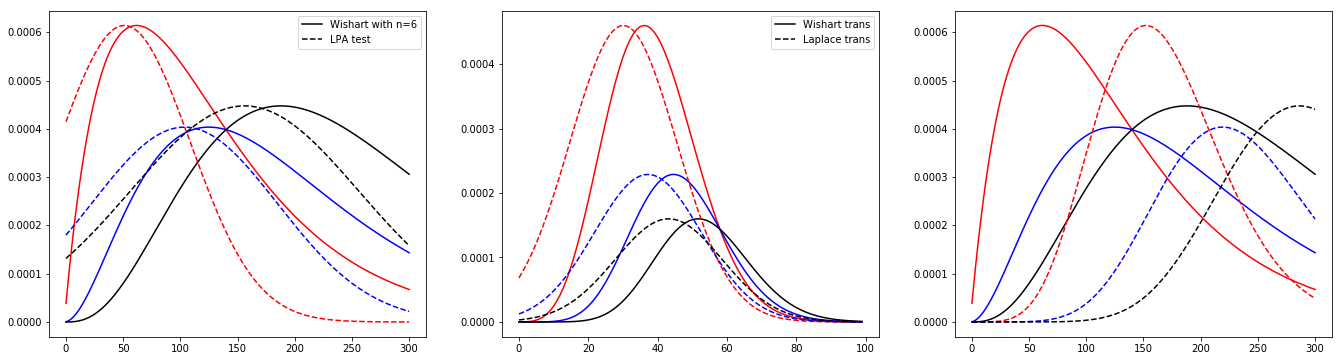

0.9
(301, 2, 2)


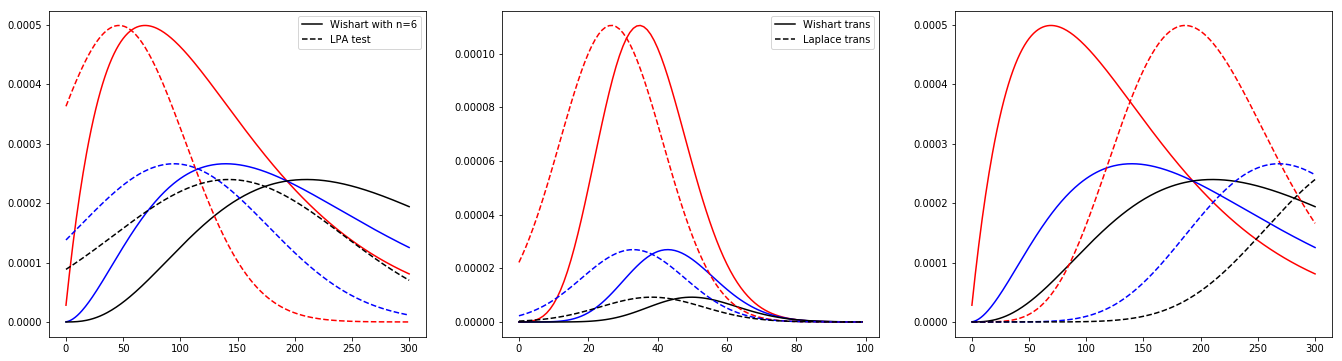

In [16]:
# test the function for multiple values of rho and s

""" values """

#s = np.eye(2)*2

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

n1 = 4
n2 = 5
n3 = 6

p=2

rhos = np.linspace(-0.9, 0.9, 19)

for r in rhos:
    
    print(r)
    xx = make_2D_psd_cone_cut(a_11, a_22, r)
    plot_Wishart_bridge_sqrtm(xx=xx, ns=[n1,n2,n3], s=s, p=2, save=False)

## logm basis

In [17]:
# function that creates a fancy plot for three different values of n
# the plot contains the original Laplace approximation, the Bridge, and a back transform

def plot_Wishart_bridge_logm(xx, ns, s, p=2, save=False):
    
    n1, n2, n3 = ns
    
    ##### normal laplace
    
    mode1 = wishart_mode(n1, p=p, V=s)
    mode2 = wishart_mode(n2, p=p, V=s)
    mode3 = wishart_mode(n3, p=p, V=s)
    #print("mode1: ", mode1)
    #print("mode2: ", mode2)
    #print("mode3: ", mode3)

    sigma1 = wishart_Sigma(n1, p=p, V=s)
    sigma2 = wishart_Sigma(n2, p=p, V=s)
    sigma3 = wishart_Sigma(n3, p=p, V=s)
    #print("sigma1: ", sigma1)
    #print("sigma2: ", sigma2)
    #print("sigma3: ", sigma3)
    
    is_pos_def(sigma1)
    is_pos_def(sigma2)
    is_pos_def(sigma3)

    w1 = []
    w2 = []
    w3 = []
    normal1 = []
    normal2 = []
    normal3 = []

    print(np.shape(xx))
    for x in xx:
        w_1 = wishart_pdf(X=x, n=n1, V=s)
        w_2 = wishart_pdf(X=x, n=n2, V=s)
        w_3 = wishart_pdf(X=x, n=n3, V=s)
        w1.append(w_1)
        w2.append(w_2)
        w3.append(w_3)
        w1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1, Sigma=sigma1)
        w2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2, Sigma=sigma2)
        w3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3, Sigma=sigma3)
        normal1.append(w1_lpa)
        normal2.append(w2_lpa)
        normal3.append(w3_lpa)

    w1 = np.array(w1)
    w2 = np.array(w2)
    w3 = np.array(w3)
    
    rescale_normal1 = np.max(w1)/np.max(normal1)
    rescale_normal2 = np.max(w2)/np.max(normal2)
    rescale_normal3 = np.max(w3)/np.max(normal3)

    normal1 = np.array(normal1) * rescale_normal1
    normal2 = np.array(normal2) * rescale_normal2
    normal3 = np.array(normal3) * rescale_normal3
    

    ######### square transformation

    mode1_t_logm = wishart_t_logm_mode(n1, p=p, V=s)
    mode2_t_logm = wishart_t_logm_mode(n2, p=p, V=s)
    mode3_t_logm = wishart_t_logm_mode(n3, p=p, V=s)

    sigma1_t_logm = wishart_t_logm_Sigma(n1, p=p, V=s, mode=mode1_t_logm)
    sigma2_t_logm = wishart_t_logm_Sigma(n2, p=p, V=s, mode=mode2_t_logm)
    sigma3_t_logm = wishart_t_logm_Sigma(n3, p=p, V=s, mode=mode3_t_logm)

    is_pos_def(sigma1_t_logm)
    is_pos_def(sigma2_t_logm)
    is_pos_def(sigma3_t_logm)

    w1_t_logm = []
    w2_t_logm = []
    w3_t_logm = []
    w1_lpa_t_logm = []
    w2_lpa_t_logm = []
    w3_lpa_t_logm = []

    for x in xx:
        w_1 = wishart_pdf_t_logm(X=x, n=n1, V=s)
        w_2 = wishart_pdf_t_logm(X=x, n=n2, V=s)
        w_3 = wishart_pdf_t_logm(X=x, n=n3, V=s)
        w1_t_logm.append(w_1)
        w2_t_logm.append(w_2)
        w3_t_logm.append(w_3)
        #
        w1_lpa = multivariate_normal_pdf_test(X=x, mu=mode1_t_logm, Sigma=sigma1_t_logm)
        w2_lpa = multivariate_normal_pdf_test(X=x, mu=mode2_t_logm, Sigma=sigma2_t_logm)
        w3_lpa = multivariate_normal_pdf_test(X=x, mu=mode3_t_logm, Sigma=sigma3_t_logm)
        w1_lpa_t_logm.append(w1_lpa)
        w2_lpa_t_logm.append(w2_lpa)
        w3_lpa_t_logm.append(w3_lpa)

    #rescale for visibility
    w1_t_logm = np.array(w1_t_logm)
    w2_t_logm = np.array(w2_t_logm)
    w3_t_logm = np.array(w3_t_logm)
    
    rescale1_t_logm = np.max(w1_t_logm)/np.max(w1_lpa_t_logm)
    rescale2_t_logm = np.max(w2_t_logm)/np.max(w2_lpa_t_logm)
    rescale3_t_logm = np.max(w3_t_logm)/np.max(w3_lpa_t_logm)

    w1_lpa_t_logm = np.array(w1_lpa_t_logm) * rescale1_t_logm
    w2_lpa_t_logm = np.array(w2_lpa_t_logm) * rescale2_t_logm
    w3_lpa_t_logm = np.array(w3_lpa_t_logm) * rescale3_t_logm

    ######### back transform #########

    w1_back = []
    w2_back = []
    w3_back = []

    for x in xx:
        w1_back.append(log_mv_normal_back(x, mode1_t_logm, sigma1_t_logm))
        w2_back.append(log_mv_normal_back(x, mode2_t_logm, sigma2_t_logm))
        w3_back.append(log_mv_normal_back(x, mode3_t_logm, sigma3_t_logm))
        
    rescale_back1 = np.max(w1)/np.max(w1_back)
    rescale_back2 = np.max(w2)/np.max(w2_back)
    rescale_back3 = np.max(w3)/np.max(w3_back)

    w1_back = np.array(w1_back) * rescale_back1
    w2_back = np.array(w2_back) * rescale_back2 
    w3_back = np.array(w3_back) * rescale_back3 

    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(23, 6))
    axs[0].plot(w1, 'r-')#, label="Wishart with n={}".format(n1));
    axs[0].plot(w2, 'b-')#, label="Wishart with n={}".format(n2));
    axs[0].plot(w3, 'k-', label="Wishart with n={}".format(n3));
    axs[0].plot(normal1, 'r--')#, label="LPA test");
    axs[0].plot(normal2, 'b--')#, label="normal approx of wishart1"'');
    axs[0].plot(normal3, 'k--', label="LPA test");
    axs[0].legend();

    axs[1].plot(w1_t_logm[:100], 'r')#, label="Wishart transformed with n={}".format(n1));
    axs[1].plot(w2_t_logm[:100], 'b')#, label="Wishart transformed with n={}".format(n2));
    axs[1].plot(w3_t_logm[:100], 'k', label="Wishart trans");
    axs[1].plot(w1_lpa_t_logm[:100], 'r--')#, label="Wishart transformed with n={}".format(n1));
    axs[1].plot(w2_lpa_t_logm[:100], 'b--')#, label="Wishart transformed with n={}".format(n2));
    axs[1].plot(w3_lpa_t_logm[:100], 'k--', label="Laplace trans");
    axs[1].legend();

    axs[2].plot(w1, 'r-')#, label="Wishart with n={}".format(n1));
    axs[2].plot(w2, 'b-')#, label="Wishart with n={}".format(n2));
    axs[2].plot(w3, 'k-', label="Wishart with n={}".format(n3));
    axs[2].plot(w1_back, 'r--')
    axs[2].plot(w2_back, 'b--')
    axs[2].plot(w3_back, 'k--', label='back transform')

    if save:
        plt.savefig('wishart_playground_logm.pdf')
    plt.show();

[[4 2]
 [2 3]]
(301, 2, 2)


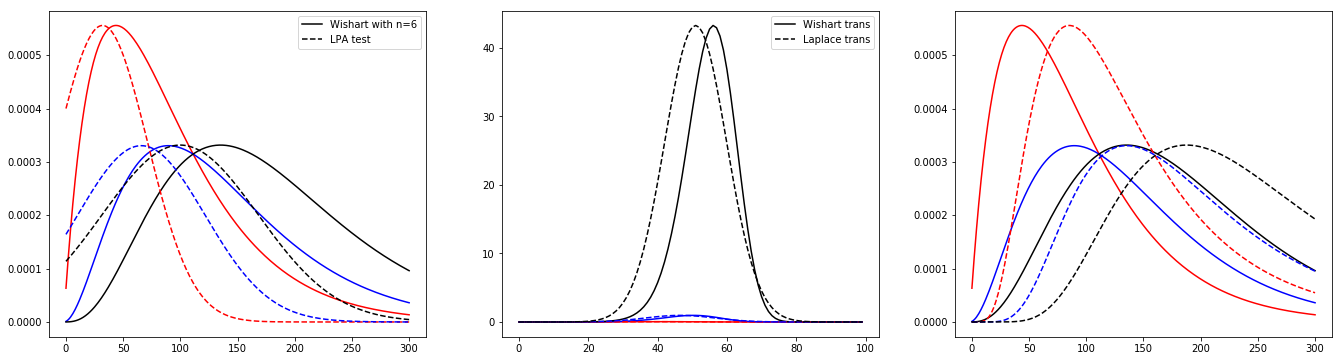

In [18]:
# test the function for one value of rho and s

""" values """
a_11 = np.linspace(0.1, 15.1, 300 +1)
a_22 = np.linspace(0.1, 15.1, 300 +1)

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

#s = 2*np.eye(2)

#s = create_spd_matrix(eps=3)
print(s)

is_pos_def(s)

r = 0
xxt = make_2D_psd_cone_cut(a_11, a_22, r)

n1 = 4
n2 = 5
n3 = 6

p=2

plot_Wishart_bridge_logm(xx=xxt, ns=[n1,n2,n3], s=s, p=2, save=False)


-0.9
(301, 2, 2)


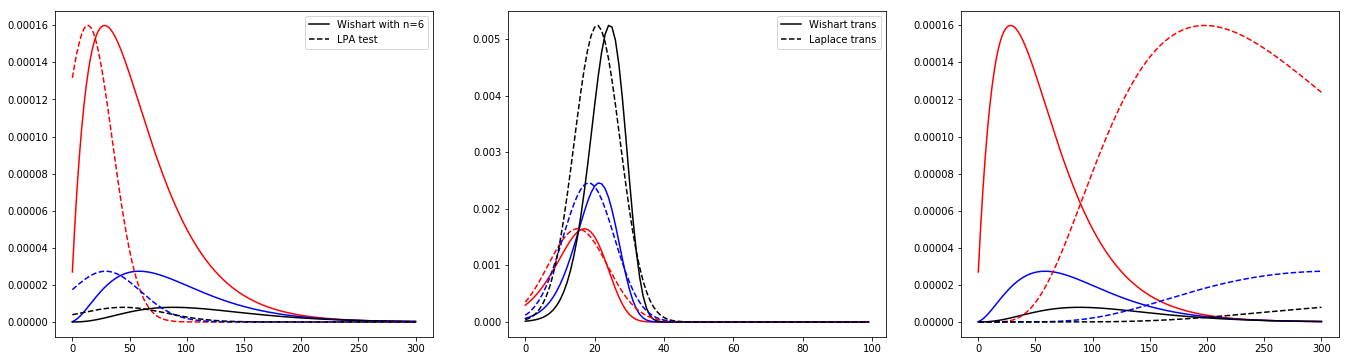

-0.8
(301, 2, 2)


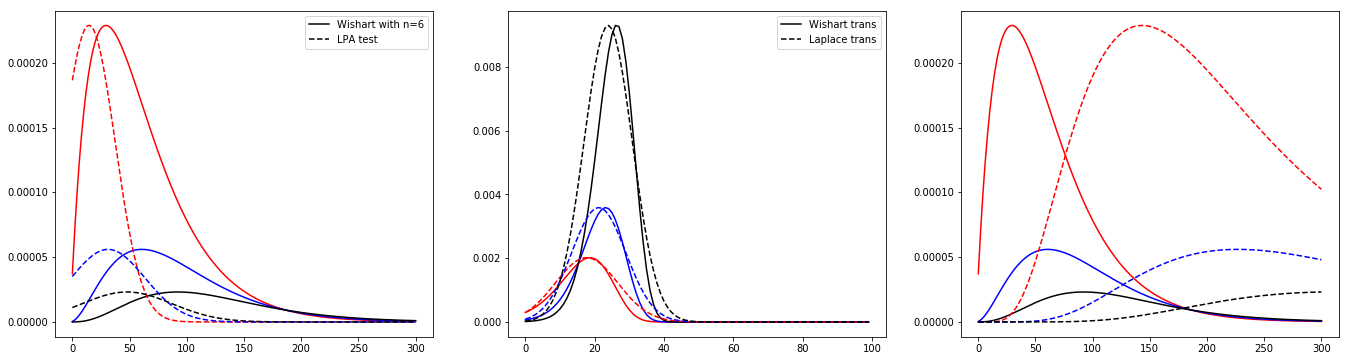

-0.7
(301, 2, 2)


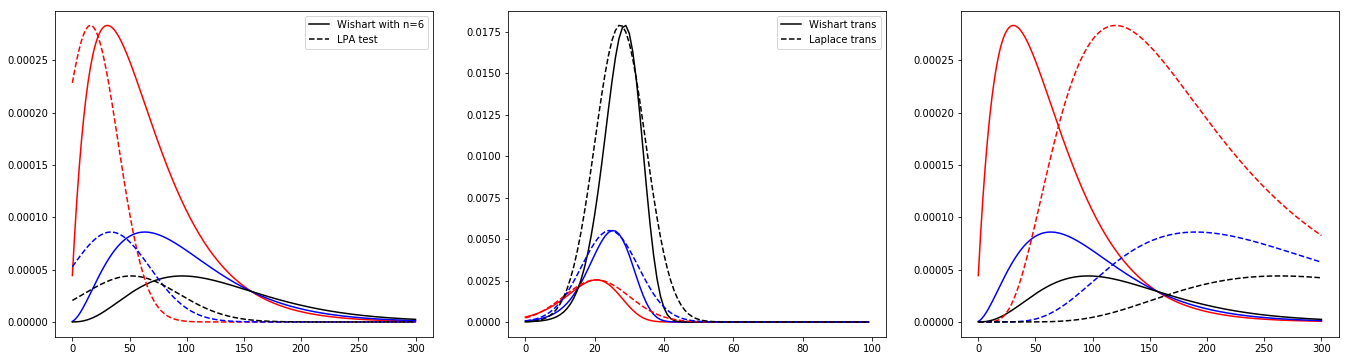

-0.6
(301, 2, 2)


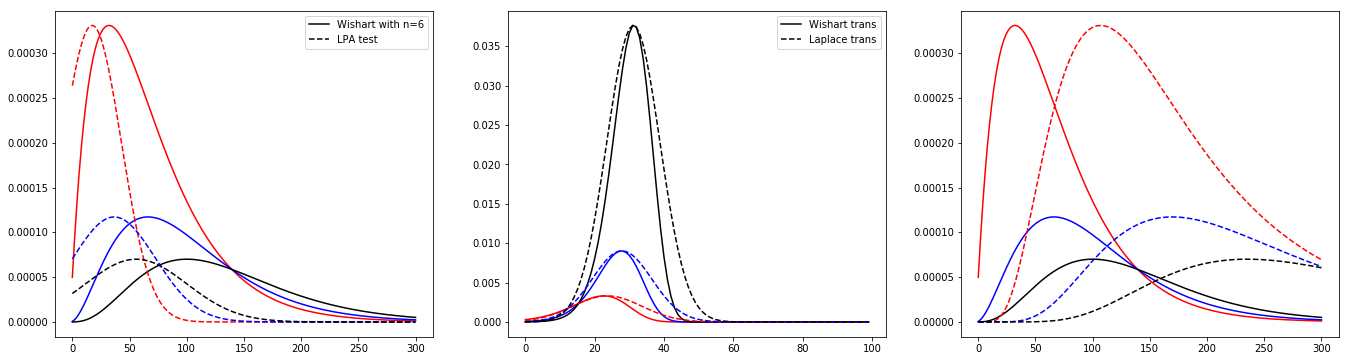

-0.5
(301, 2, 2)


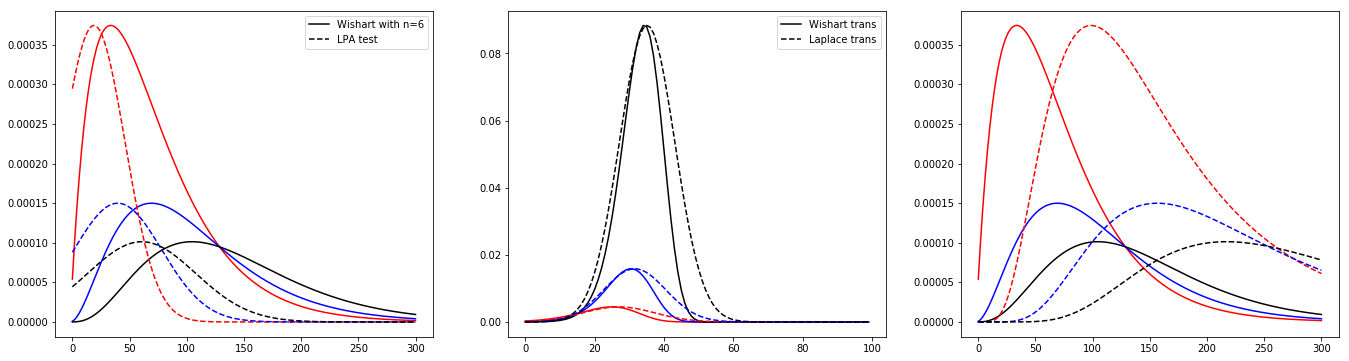

-0.4
(301, 2, 2)


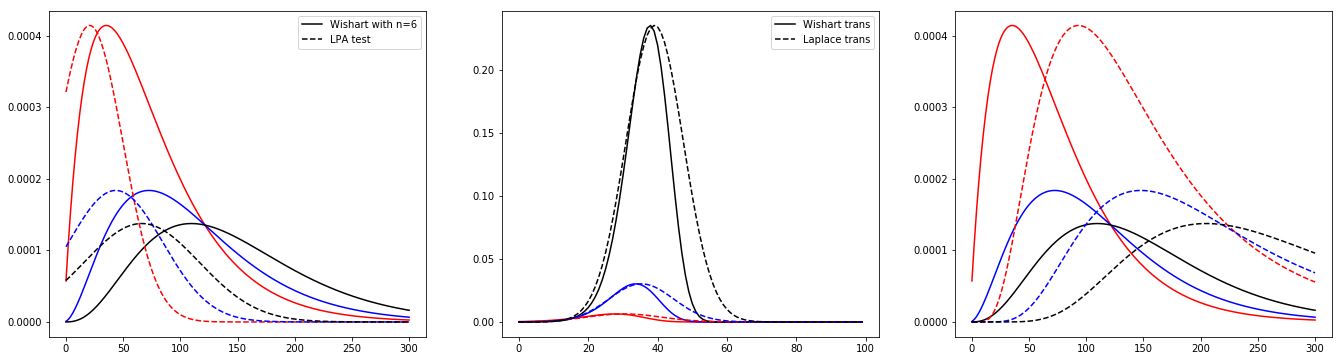

-0.29999999999999993
(301, 2, 2)


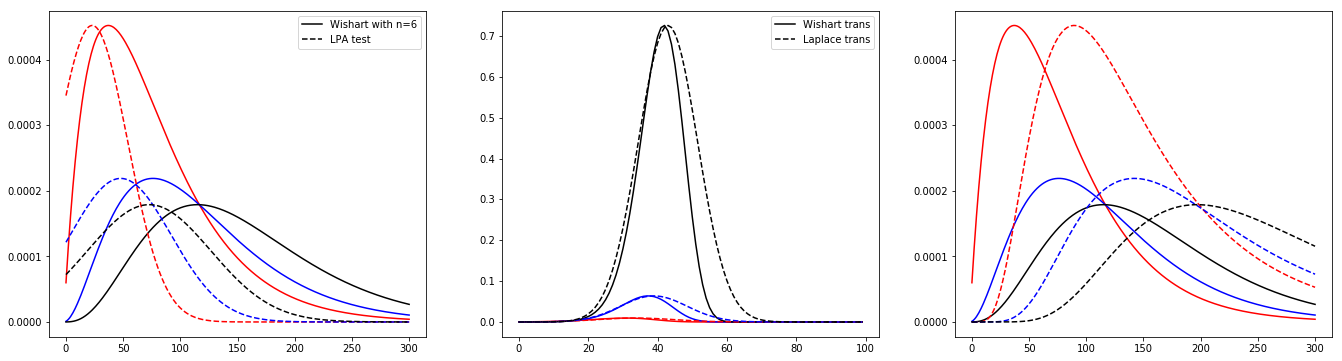

-0.19999999999999996
(301, 2, 2)


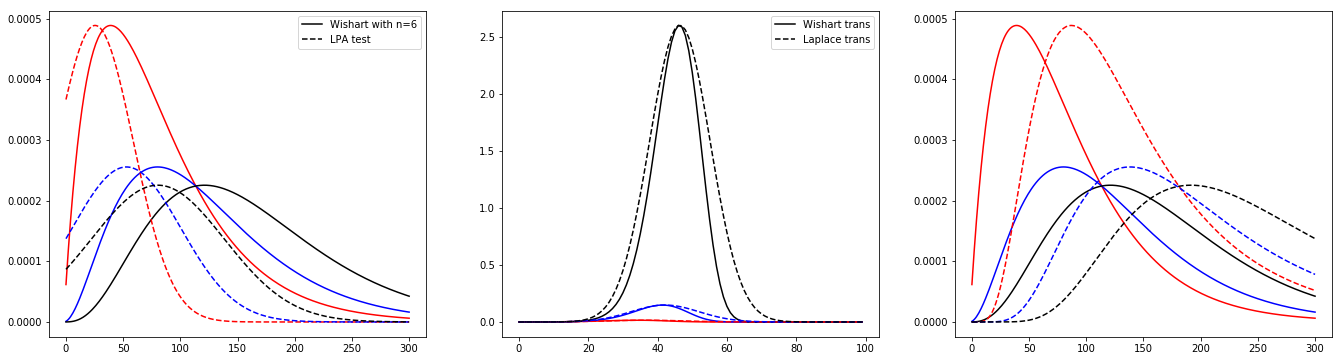

-0.09999999999999998
(301, 2, 2)


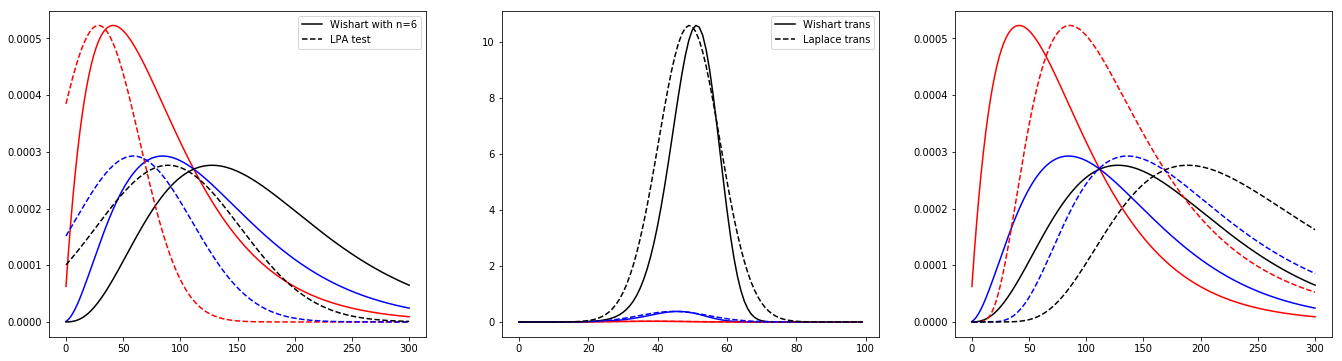

0.0
(301, 2, 2)


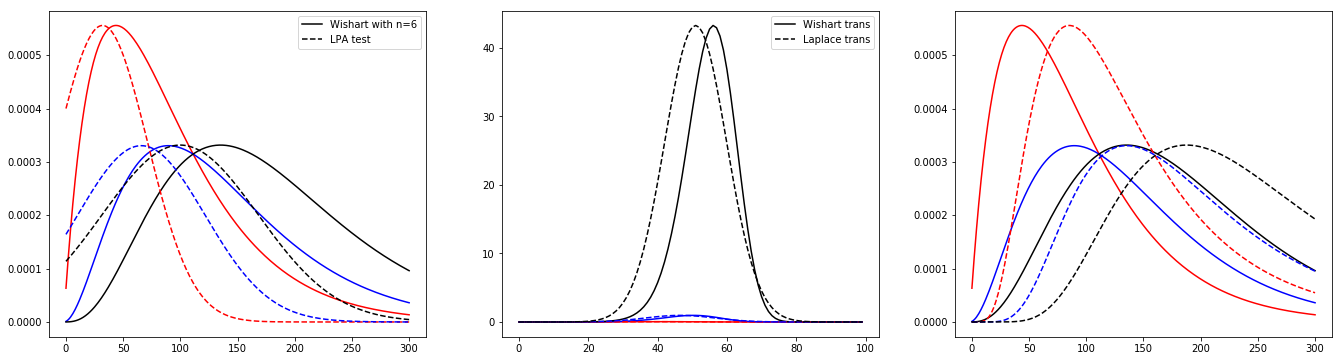

0.09999999999999998
(301, 2, 2)


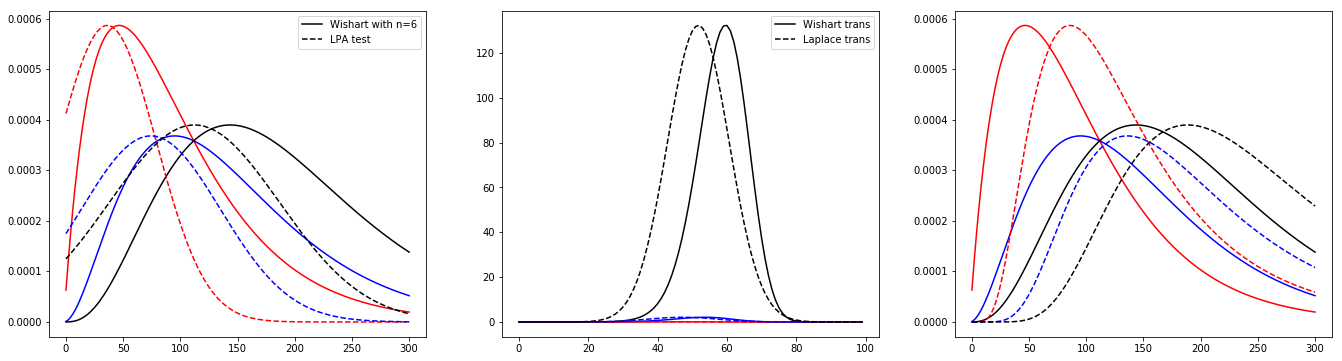

0.20000000000000007
(301, 2, 2)


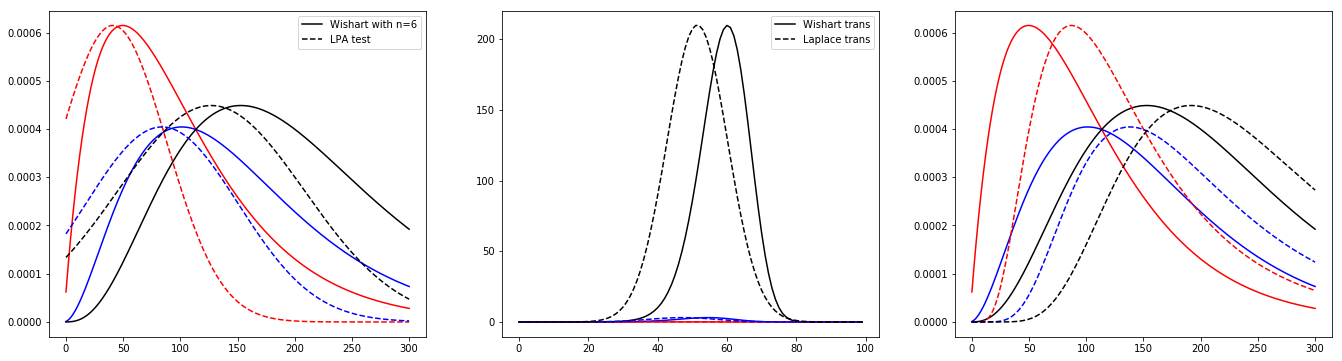

0.30000000000000016
(301, 2, 2)


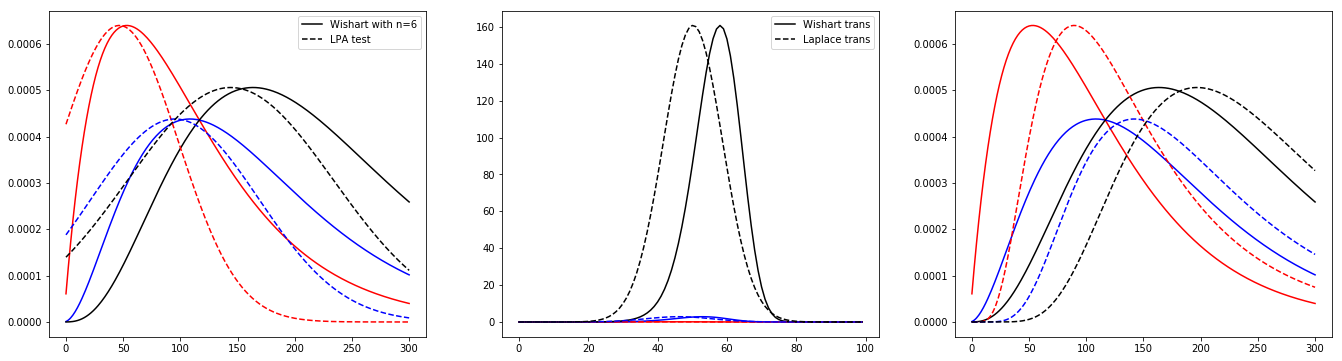

0.4
(301, 2, 2)


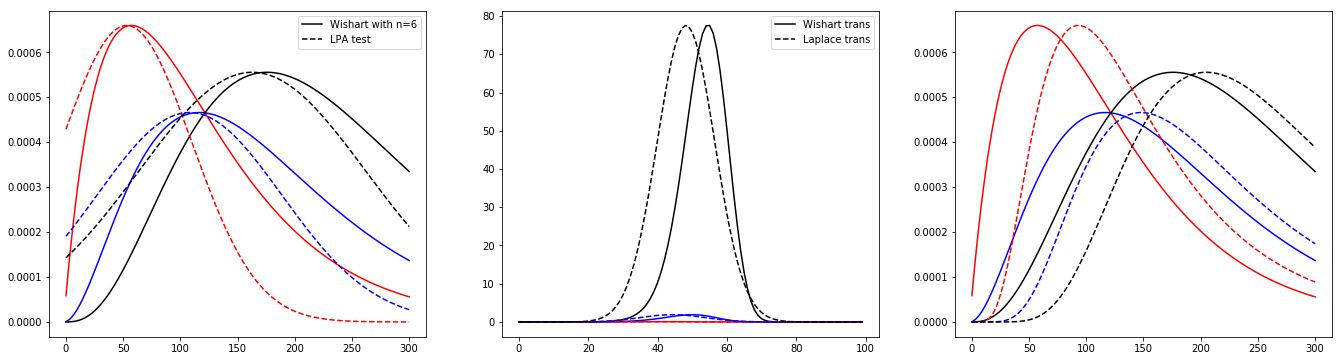

0.5000000000000001
(301, 2, 2)


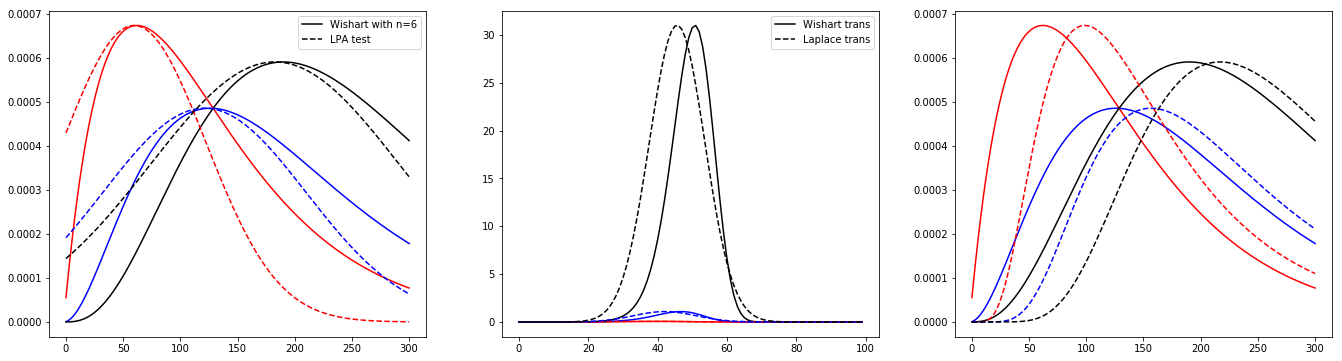

0.6
(301, 2, 2)


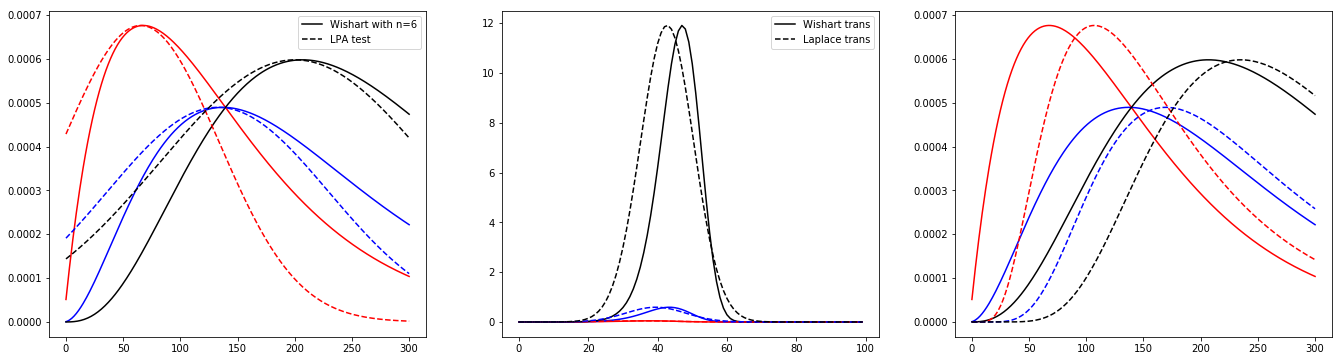

0.7000000000000001
(301, 2, 2)


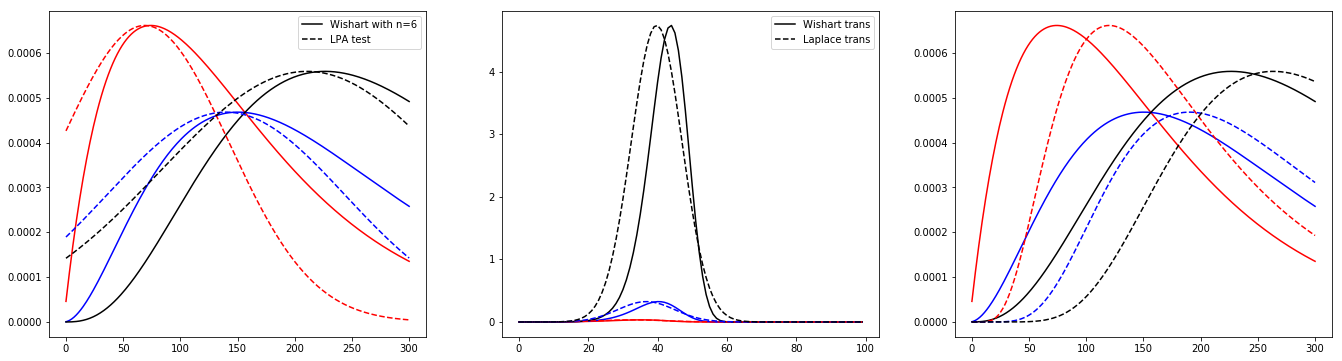

0.8000000000000002
(301, 2, 2)


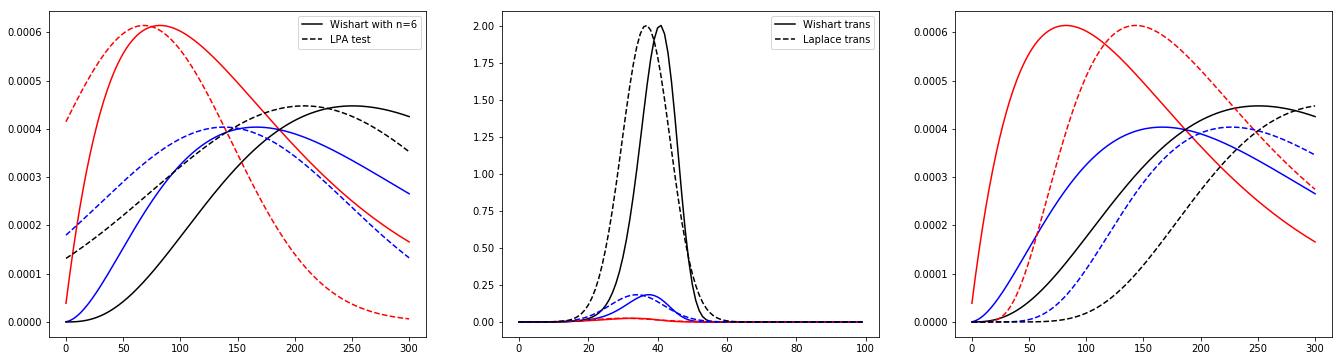

0.9
(301, 2, 2)


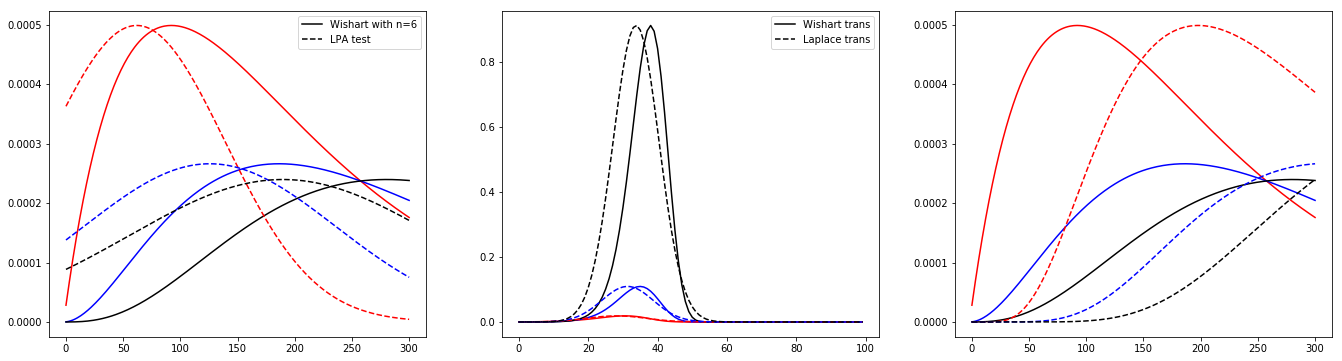

In [19]:
# test the function for multiple values of rho and s

""" values """

#s = np.eye(2)*2

#s = np.array([[4,2],
#             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

is_pos_def(s)

n1 = 4
n2 = 5
n3 = 6

p=2

rhos = np.linspace(-0.9, 0.9, 19)

for r in rhos:
    
    print(r)
    xx = make_2D_psd_cone_cut(a_11, a_22, r)
    plot_Wishart_bridge_logm(xx=xx, ns=[n1,n2,n3], s=s, p=2, save=False)

# Verify the Bridge

In [22]:
n_test = 5
p_test = 2
s_test = np.array([[4,2],
                   [2,3]])

is_pos_def(s_test)

def wishart_t_logm_mode(n, p, V):
    return(logm((n-p+1) * V))

def wishart_t_logm_Sigma(n, p, V):
    return(2/(n-p+1) * np.eye(p**2))

def wishart_t_logm_V_from_mS(mu, Sigma, p, n):
    mu_ = mu.reshape(p,p)
    return(expm(mu_)/(n-p+1))

def wishart_t_logm_n_from_mS(mu, Sigma, p, V):
    mu_ = mu.reshape(p,p)
    return(expm(mu)@np.linalg.inv(V) + (p-1)*np.eye(p))

def wishart_t_logm_n_from_mS2(mu, Sigma, p):
    S_inv = np.linalg.inv(Sigma)
    return(2*S_inv + (p-1)*np.eye(p**2))

m_test = wishart_t_logm_mode(n_test, p_test, s_test)
S_test = wishart_t_logm_Sigma(n_test, p_test, s_test)
V_test = wishart_t_logm_V_from_mS(m_test, S_test, p_test, n_test)
print(m_test)
print(S_test)

n2_test = wishart_t_logm_n_from_mS(m_test, S_test, p_test, V_test)
n3_test = wishart_t_logm_n_from_mS2(m_test, S_test, p_test)

print(V_test)
print(n2_test)
print(n3_test)

[[2.59000719 0.65596824]
 [0.65596824 2.26202307]]
[[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0.5]]
[[4. 2.]
 [2. 3.]]
[[5. 0.]
 [0. 5.]]
[[5. 0. 0. 0.]
 [0. 5. 0. 0.]
 [0. 0. 5. 0.]
 [0. 0. 0. 5.]]


In [21]:
X_test = create_spd_matrix(p=4)
m_ = np.random.random((4))
n2_test = wishart_t_logm_n_from_mS2(m_, X_test, p=2).diagonal().mean()
V2_test = wishart_t_logm_V_from_mS(m_, X_test, 2, n2_test)
print(X_test)
print(m_)
print(n2_test)

m2_test = wishart_t_logm_mode(n2_test, 2, V2_test)
S2_test = wishart_t_logm_Sigma(n2_test, 2, V2_test)

print(m2_test)
print("X': ", S2_test)


X_spd is spd:  True
[[1.3344936  0.34415627 0.6678269  0.6412133 ]
 [0.34415627 1.1441565  0.93252444 0.30965585]
 [0.6678269  0.93252444 0.9011847  0.37439555]
 [0.6412133  0.30965585 0.37439555 1.2558683 ]]
[0.74356068 0.96954257 0.73672819 0.88248571]
52.36150801181793
[[0.74356068 0.96954257]
 [0.73672819 0.88248571]]
X':  [[0.03893967 0.         0.         0.        ]
 [0.         0.03893967 0.         0.        ]
 [0.         0.         0.03893967 0.        ]
 [0.         0.         0.         0.03893967]]


# Visualization

we follow the 4-layer visualization approach by Gelman (http://www.stat.columbia.edu/~gelman/research/unpublished/Visualization.pdf)

In [15]:
from scipy.stats import wishart

In [7]:
s = np.array([[4,2],
             [2,3]])

n1 = 5

num_samples=25000

wishart_samples = wishart.rvs(df=n1, scale=s, size=num_samples, random_state=None)

In [17]:
print(np.shape(wishart_samples))
print(wishart_samples[0])

(25000, 2, 2)
[[12.90761541  4.03934443]
 [ 4.03934443  3.82235512]]


In [18]:
sigma_00 = np.sqrt(wishart_samples[:,0,0])
sigma_11 = np.sqrt(wishart_samples[:,1,1])
sigma_01 = wishart_samples[:,0,1]
rho_01 = sigma_01/(sigma_00 * sigma_11)

In [19]:
def plot_histograms(samples_2D, sqrt=True):
    
    #get values
    samples_flat = samples_2D.reshape(len(samples_2D), -1)
    if sqrt:
        sigma_00 = np.sqrt(samples_flat[:,0]) 
    else:
        sigma_00 = samples_flat[:,0]
    sigma_01 = samples_flat[:,1]
    sigma_10 = samples_flat[:,2]
    if sqrt:
        sigma_11 = np.sqrt(samples_flat[:,3])
    else:
        sigma_11 = samples_flat[:,3]
    rho_01 = sigma_01/(sigma_00 * sigma_11)  
    rho_10 = sigma_10/(sigma_00 * sigma_11)  
    
    #plot values
    fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False, figsize=(12, 17))
    axs[0][0].hist(sigma_00, bins=100)
    axs[0][0].set_title("sigma_00")
    axs[0][1].hist(sigma_01, bins=100)
    axs[0][1].set_title("sigma_01")
    axs[1][0].hist(sigma_10, bins=100)
    axs[1][0].set_title("sigma_10")
    axs[1][1].hist(sigma_11, bins=100)
    axs[1][1].set_title("sigma_11")
    axs[2][0].hist(rho_01, bins=100)
    axs[2][0].set_title("rho_01")
    axs[2][1].hist(rho_10, bins=100)
    axs[2][1].set_title("rho_10")
    
    plt.show()

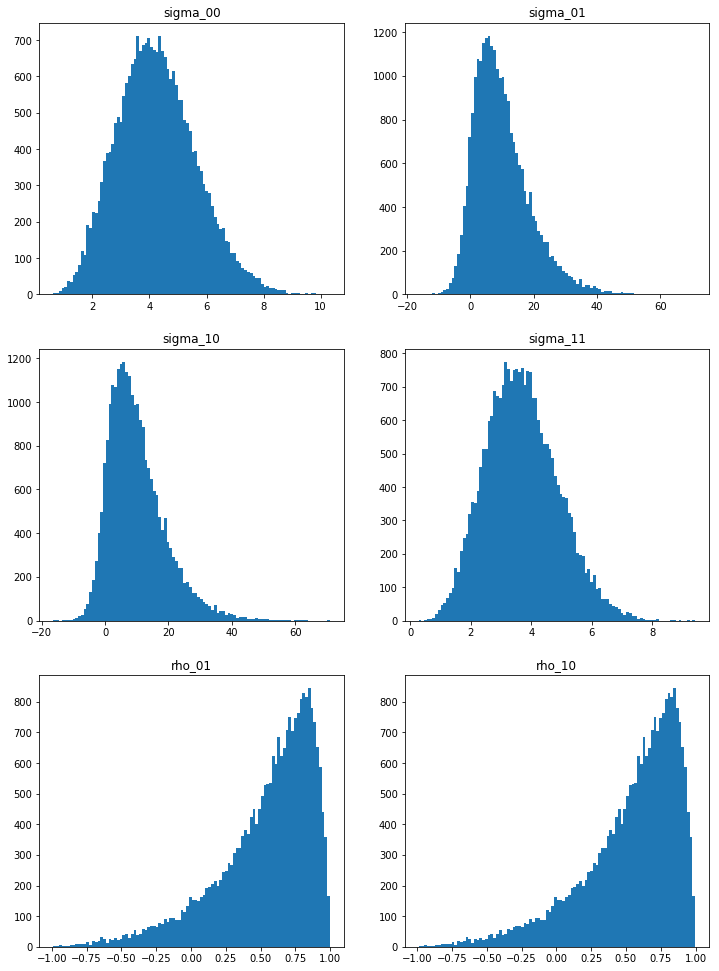

In [20]:
plot_histograms(wishart_samples, sqrt=True)

In [21]:
wishart_samples_sqrtm = np.array([sqrtm(x) for x in wishart_samples])
wishart_samples_1000_sqrtm = np.array([sqrtm(x) for x in wishart_samples_1000])
print(np.shape(wishart_samples_sqrtm))
print(wishart_samples_sqrtm[0])

(25000, 2, 2)
[[3.51133738 0.76034548]
 [0.76034548 1.80117458]]


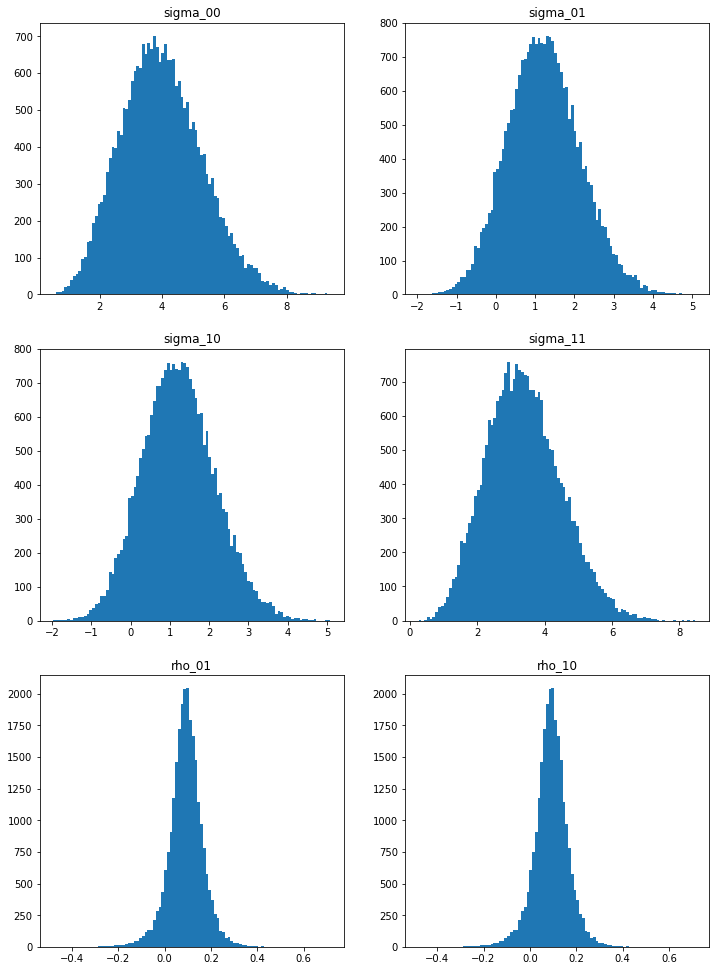

In [22]:
plot_histograms(wishart_samples_sqrtm, sqrt=False)

In [23]:
wishart_samples_logm = np.array([logm(x) for x in wishart_samples])
print(np.shape(wishart_samples_logm))
print(wishart_samples_logm[0])

(25000, 2, 2)
[[2.43734472 0.61246003]
 [0.61246003 1.05980465]]


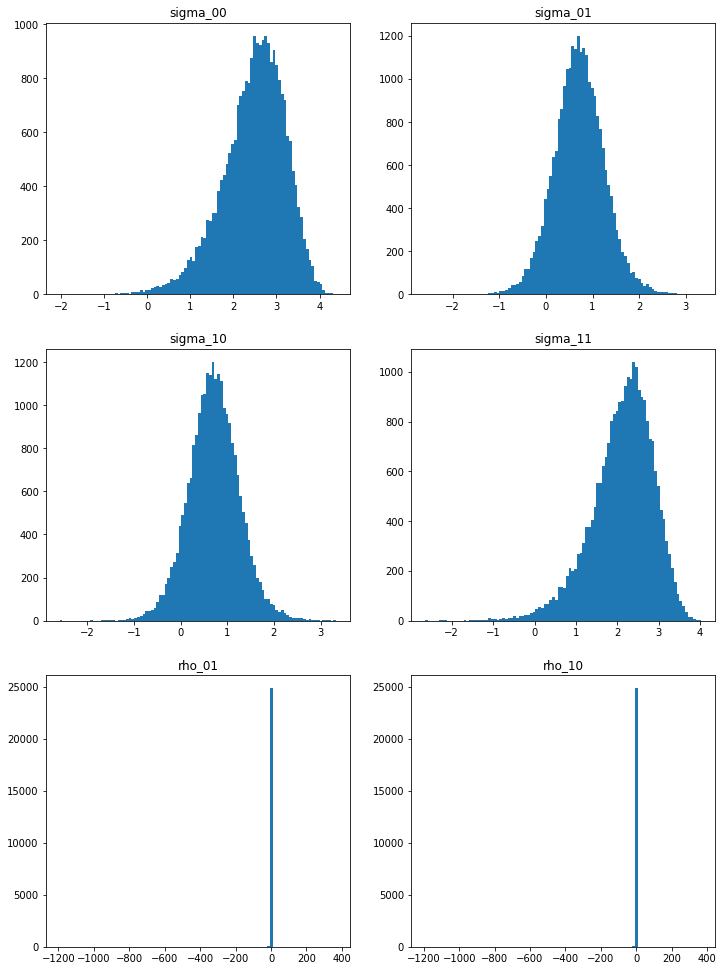

In [24]:
plot_histograms(wishart_samples_logm, sqrt=False)

In [10]:
mode1 = wishart_mode(n1, p=2, V=s).reshape(-1)
print("mode1: ", mode1)

Sigma1 = wishart_Sigma(n1, p=2, V=s)
print("sigma1: ", Sigma1)
    
is_pos_def(Sigma1)

NameError: name 'wishart_mode' is not defined

In [26]:
def plot_histograms_compare(samples_Wishart, samples_Gaussian, sqrt=True):
    
    #get values for the Wishart
    samples_flat = samples_Wishart.reshape(len(samples_Wishart), -1)
    if sqrt:
        sigma_00 = np.sqrt(samples_flat[:,0]) 
    else:
        sigma_00 = samples_flat[:,0]
    sigma_01 = samples_flat[:,1]
    sigma_10 = samples_flat[:,2]
    if sqrt:
        sigma_11 = np.sqrt(samples_flat[:,3])
    else:
        sigma_11 = samples_flat[:,3]
    rho_01 = sigma_01/(sigma_00 * sigma_11)  
    rho_10 = sigma_10/(sigma_00 * sigma_11) 
    
    #get values for the Gaussian
    samples_G = samples_Gaussian.reshape(len(samples_Gaussian), -1)
    if sqrt:
        sigma_G_00 = np.sqrt(samples_G[:,0]) 
    else:
        sigma_G_00 = samples_G[:,0]
    sigma_G_01 = samples_G[:,1]
    sigma_G_10 = samples_G[:,2]
    if sqrt:
        sigma_G_11 = np.sqrt(samples_G[:,3])
    else:
        sigma_G_11 = samples_G[:,3]
    rho_G_01 = sigma_G_01/(sigma_G_00 * sigma_G_11)  
    rho_G_10 = sigma_G_10/(sigma_G_00 * sigma_G_11) 
    
    #plot values
    a = 0.5
    fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False, figsize=(12, 17))
    axs[0][0].hist(sigma_00, bins=100, alpha=a)
    axs[0][0].hist(sigma_G_00, bins=100, alpha=a)
    axs[0][0].set_title("sigma_00")
    axs[0][1].hist(sigma_01, bins=100, alpha=a)
    axs[0][1].hist(sigma_G_01, bins=100, alpha=a)
    axs[0][1].set_title("sigma_01")
    axs[1][0].hist(sigma_10, bins=100, alpha=a)
    axs[1][0].hist(sigma_G_10, bins=100, alpha=a)
    axs[1][0].set_title("sigma_10")
    axs[1][1].hist(sigma_11, bins=100, alpha=a)
    axs[1][1].hist(sigma_G_11, bins=100, alpha=a)
    axs[1][1].set_title("sigma_11")
    axs[2][0].hist(rho_01, bins=100, alpha=a)
    axs[2][0].hist(rho_G_01, bins=100, alpha=a)
    axs[2][0].set_title("rho_01")
    axs[2][1].hist(rho_10, bins=100, alpha=a)
    axs[2][1].hist(rho_G_10, bins=100, alpha=a)
    axs[2][1].set_title("rho_10")
    
    plt.show()

In [9]:
from scipy.stats import multivariate_normal as mv_norm

mv_norm_samples = mv_norm.rvs(mean=mode1, cov=Sigma1, size=num_samples)

NameError: name 'mode1' is not defined

In [28]:
print(np.shape(mv_norm_samples))
print(mv_norm_samples[0])

(25000, 4)
[10.98112803 -1.16755399 17.72950392  9.27294076]


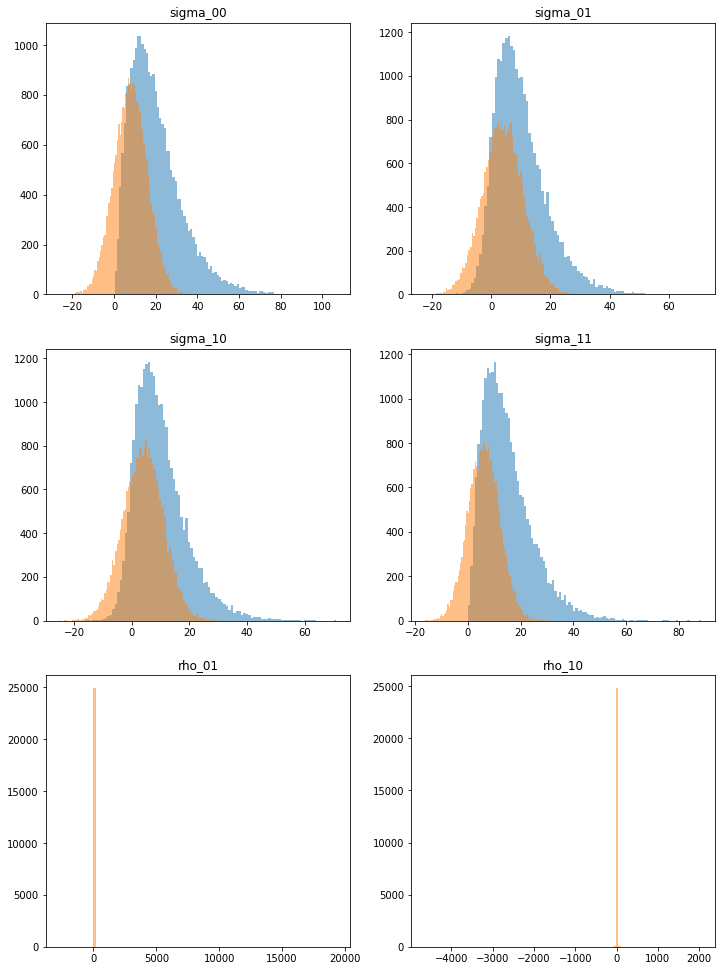

In [29]:
plot_histograms_compare(wishart_samples, mv_norm_samples, sqrt=False)

In [30]:
mode1_sqrtm = wishart_t_sqrtm_mode(n1, p=2, V=s)
print("mode1: ", mode1_sqrtm)

Sigma1_sqrtm = wishart_t_sqrtm_Sigma(n1, p=2, V=s, mode=mode1_sqrtm)
print("sigma1: ", Sigma1_sqrtm)
    
is_pos_def(Sigma1_sqrtm)
mode1_sqrtm = mode1_sqrtm.reshape(-1)

mv_norm_samples_sqrtm = mv_norm.rvs(mean=mode1_sqrtm, cov=Sigma1_sqrtm, size=num_samples)

mode1:  [[3.32443937 0.97370575]
 [0.97370575 2.8375865 ]]
sigma1:  [[ 1.84862476  0.04359094  1.69876335  0.81804191]
 [ 1.69876335  2.37855343 -0.56126844 -0.36543002]
 [ 0.04359094  0.26631777  2.37855343  1.2897424 ]
 [ 0.81804191  1.2897424  -0.36543002  1.18195809]]


/home/marius/anaconda3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:660: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


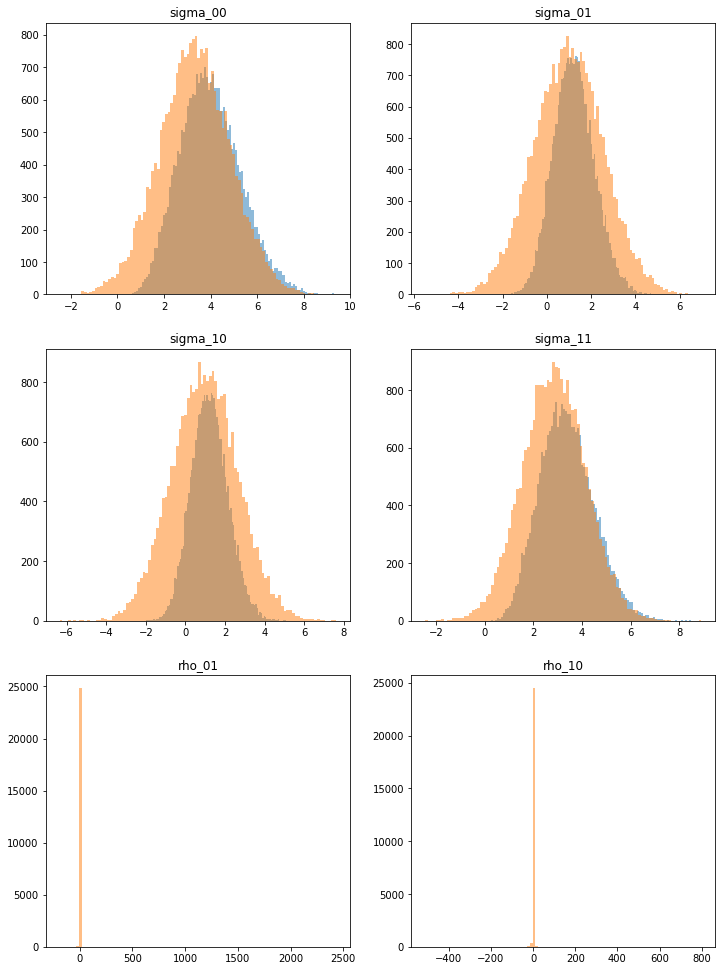

In [31]:
plot_histograms_compare(wishart_samples_sqrtm, mv_norm_samples_sqrtm, sqrt=False)

In [17]:
n1 = 5

s = np.array([[4,2],
             [2,3]])

mode1 = wishart_mode(n1, p=2, V=s).reshape(-1)
print("mode1: ", mode1)

Sigma1 = wishart_Sigma(n1, p=2, V=s)
print("sigma1: ", Sigma1)
    
is_pos_def(Sigma1)

mode1_sqrtm = wishart_t_sqrtm_mode(n1, p=2, V=s)
print("mode1: ", mode1_sqrtm)

Sigma1_sqrtm = wishart_t_sqrtm_Sigma(n1, p=2, V=s, mode=mode1_sqrtm)
print("sigma1: ", Sigma1_sqrtm)
    
is_pos_def(Sigma1_sqrtm)
mode1_sqrtm = mode1_sqrtm.reshape(-1)

wishart_samples_1000 = wishart.rvs(df=n1, scale=s, size=1000, random_state=None)
wishart_samples_1000_logm = np.array([logm(x) for x in wishart_samples_1000])
wishart_samples_1000_sqrtm = np.array([sqrtm(x) for x in wishart_samples_1000])
mv_norm_samples_1000 = mv_norm.rvs(mean=mode1, cov=Sigma1, size=1000)
mv_norm_samples_1000_sqrtm = mv_norm.rvs(mean=mode1_sqrtm, cov=Sigma1_sqrtm, size=1000)

mode1:  [8 4 4 6]
sigma1:  [[64. 32. 32. 16.]
 [32. 48. 16. 24.]
 [32. 16. 48. 24.]
 [16. 24. 24. 36.]]
mode1:  [[3.32443937 0.97370575]
 [0.97370575 2.8375865 ]]
sigma1:  [[ 1.84862476  0.04359094  1.69876335  0.81804191]
 [ 1.69876335  2.37855343 -0.56126844 -0.36543002]
 [ 0.04359094  0.26631777  2.37855343  1.2897424 ]
 [ 0.81804191  1.2897424  -0.36543002  1.18195809]]


## other way to visualize 4D matrices

In [32]:
import plotly
import plotly.graph_objs as go


def plot_samples_4D(samples):
    
    #reshape
    data = samples.reshape((len(samples), -1))

    #Set marker properties
    markercolor = data[:,2]

    #Make Plotly figure
    fig1 = go.Scatter3d(x=data[:,0],
                        y=data[:,1],
                        z=data[:,3],
                        marker=dict(color=markercolor,
                                    opacity=1,
                                    reversescale=True,
                                    colorscale='Blues',
                                    size=5),
                        line=dict (width=0.02),
                        mode='markers')

    #Make Plot.ly Layout
    mylayout = go.Layout(scene=dict(xaxis=dict( title="sigma_00"),
                                    yaxis=dict( title="sigma_01"), 
                                    zaxis=dict(title="sigma_11")))

    #Plot and save html
    plotly.offline.plot({"data": [fig1],
                         "layout": mylayout},
                         auto_open=True,
                         filename=("4DPlot.html"))

In [33]:
plot_samples_4D(wishart_samples_1000)

In [34]:
plot_samples_4D(mv_norm_samples_1000)

In [35]:
plot_samples_4D(wishart_samples_1000_sqrtm)

In [36]:
plot_samples_4D(mv_norm_samples_1000_sqrtm)

# statistical measures

In [37]:
from sklearn.decomposition import PCA

## I'm not sure whether we gain anything by looking at the principal components

In [38]:
# PCA for wishart samples
pca_W = PCA(n_components=4)
pca_W.fit(wishart_samples.reshape(num_samples, -1))
print("explained variance ratio: ", pca_W.explained_variance_ratio_)
print("singular values: ", pca_W.singular_values_)
print("components: ", pca_W.components_)

explained variance ratio:  [7.53679446e-01 1.96197994e-01 5.01225602e-02 2.16500090e-33]
singular values:  [2.78252962e+03 1.41969071e+03 7.17568033e+02 1.49133600e-13]
components:  [[ 6.19757495e-01  4.86331760e-01  4.86331760e-01  3.77972864e-01]
 [-6.87636077e-01  1.72382696e-01  1.72382696e-01  6.83904261e-01]
 [ 3.78229128e-01 -4.83493149e-01 -4.83493149e-01  6.24028426e-01]
 [ 0.00000000e+00 -7.07106781e-01  7.07106781e-01  2.54352480e-16]]


In [39]:
# PCA for Gaussian samples
pca_N = PCA(n_components=4)
pca_N.fit(mv_norm_samples.reshape(num_samples, -1))
print("explained variance ratio: ", pca_N.explained_variance_ratio_)
print("singular values: ", pca_N.singular_values_)
print("components: ", pca_N.components_)

explained variance ratio:  [0.63055645 0.16467044 0.1630643  0.04170882]
singular values:  [1758.71116784  898.75300135  894.35919598  452.32073106]
components:  [[-0.62284098 -0.48703542 -0.48145786 -0.37823795]
 [ 0.31269788  0.54681832 -0.70954011 -0.31585218]
 [-0.60875844  0.47573622 -0.17351257  0.61072219]
 [-0.37908088  0.48729999  0.48440123 -0.61983212]]


In [40]:
# PCA for wishart samples in sqrtm basis
pca_W_sqrtm = PCA(n_components=4)
pca_W_sqrtm.fit(wishart_samples_sqrtm.reshape(num_samples, -1))
print("explained variance ratio: ", pca_W_sqrtm.explained_variance_ratio_)
print("singular values: ", pca_W_sqrtm.singular_values_)
print("components: ", pca_W_sqrtm.components_)

explained variance ratio:  [5.76752276e-01 2.76290947e-01 1.46956777e-01 2.98493497e-32]
singular values:  [2.58065490e+02 1.78615277e+02 1.30265702e+02 5.87087334e-14]
components:  [[ 6.09142684e-01  5.00367835e-01  5.00367835e-01  3.58063193e-01]
 [ 6.86930397e-01 -1.73351626e-01 -1.73351626e-01 -6.84123569e-01]
 [ 3.96322875e-01 -4.68594968e-01 -4.68594968e-01  6.35425599e-01]
 [ 0.00000000e+00 -7.07106781e-01  7.07106781e-01 -6.73533666e-16]]


In [41]:
# PCA for Gaussian samples in sqrtm basis
pca_N_sqrtm = PCA(n_components=4)
pca_N_sqrtm.fit(mv_norm_samples_sqrtm.reshape(num_samples, -1))
print("explained variance ratio: ", pca_N_sqrtm.explained_variance_ratio_)
print("singular values: ", pca_N_sqrtm.singular_values_)
print("components: ", pca_N_sqrtm.components_)

explained variance ratio:  [0.40011752 0.35062394 0.14436741 0.10489114]
singular values:  [303.55998844 284.1656137  182.34141558 155.42473619]
components:  [[-0.63600685 -0.53382513 -0.42696288 -0.35809038]
 [-0.22722909 -0.53684273  0.75233698  0.30684833]
 [-0.64044191  0.45041442 -0.1209082   0.6101985 ]
 [-0.36564517  0.47324144  0.4869014  -0.63661069]]


# test with MMD statistics

In [14]:
from torch_two_sample import MMDStatistic

In [20]:
MMD_test = MMDStatistic(1000, 1000)

W = torch.Tensor(wishart_samples_1000.reshape((1000, -1)))
mvN = torch.Tensor(mv_norm_samples_1000.reshape((1000, -1)))
MMD_test_value, matrix = MMD_test(W, mvN,  alphas=[0.5], ret_matrix=True)

print(MMD_test_value)
print(matrix.size())
print(MMD_test.pval(matrix))

tensor(0.0009)
torch.Size([2000, 2000])
0.0


In [21]:
MMD_test = MMDStatistic(1000, 1000)

W_sqrtm = torch.Tensor(wishart_samples_1000_sqrtm.reshape((1000, -1)))
mvN_sqrtm = torch.Tensor(mv_norm_samples_1000_sqrtm.reshape((1000, -1)))
MMD_test_value_sqrtm, matrix_sqrtm = MMD_test(W_sqrtm, mvN_sqrtm,  alphas=[0.5], ret_matrix=True)

print(MMD_test_value_sqrtm)
print(matrix_sqrtm.size())
print(MMD_test.pval(matrix_sqrtm))

tensor(0.0673)
torch.Size([2000, 2000])
0.0


In [43]:
#check some derivations

def der_AX(A):
    
    n = A.shape[0]
    K = np.zeros((n**2, n**2))
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                for l in range(n):
                    x1 = A[k,i] if l == j else 0
                    K[n*k + j, n*i + l] = x1

    return(K)

In [46]:
s = np.array([[4,2],
             [2,3]])

print(der_AX(A=s))
print(np.kron(s, np.eye(2)))

[[4. 0. 2. 0.]
 [0. 4. 0. 2.]
 [2. 0. 3. 0.]
 [0. 2. 0. 3.]]
[[4. 0. 2. 0.]
 [0. 4. 0. 2.]
 [2. 0. 3. 0.]
 [0. 2. 0. 3.]]
